<a href="https://colab.research.google.com/github/furlancad/PythonFinancas/blob/main/Sele%C3%A7%C3%A3o_de_Carteira_e_Teoria_de_Markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CARREGAMENTO DE BIBLIOTECAS

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
from plotnine import *
import seaborn as sns
sns.set()

## 2. COLETA E TRATAMENTO DE DADOS

In [16]:
# Display para formato em %
pd.options.display.float_format = '{:.4%}'.format

# Período
start = '2016-01-01'
end = '2022-12-30'

# Tickers dos ativos
assets = ['BBDC4.SA', 'ITSA4.SA', 'GGBR4.SA', 'WEGE3.SA']

# Baixa os dados (dados mensais)
data = yf.download(assets, start = start, end = end, interval = '1mo', progress = False)
data = data.loc[:, ('Adj Close', slice(None))]
data.columns = assets

#----------------------------------------------------------------------------------------------#


In [17]:
# Calculando os retornos
Y = data[assets].pct_change().dropna()

print(Y.shape)
display(Y.head(10))

#----------------------------------------------------------------------------------------------#


(83, 4)


,BBDC4.SA,ITSA4.SA,GGBR4.SA,WEGE3.SA
Date,,,,
2016-02-01,17.6933%,-1.9444%,-0.8721%,-14.6831%
2016-03-01,26.9335%,85.2691%,23.1513%,7.1198%
2016-04-01,5.3757%,19.4190%,6.2312%,8.4479%
2016-05-01,-11.9086%,-28.6812%,-9.3072%,-5.2043%
2016-06-01,10.5212%,5.7451%,6.3025%,-4.5170%
2016-07-01,13.5886%,31.5790%,10.3769%,11.6776%
2016-08-01,2.5443%,17.1613%,2.8708%,8.2515%
2016-09-01,2.1673%,-2.1192%,-2.1346%,7.0906%
2016-10-01,12.7809%,24.3792%,13.3872%,-0.0076%


## CONJUNTO DE OPORTUNIDADES

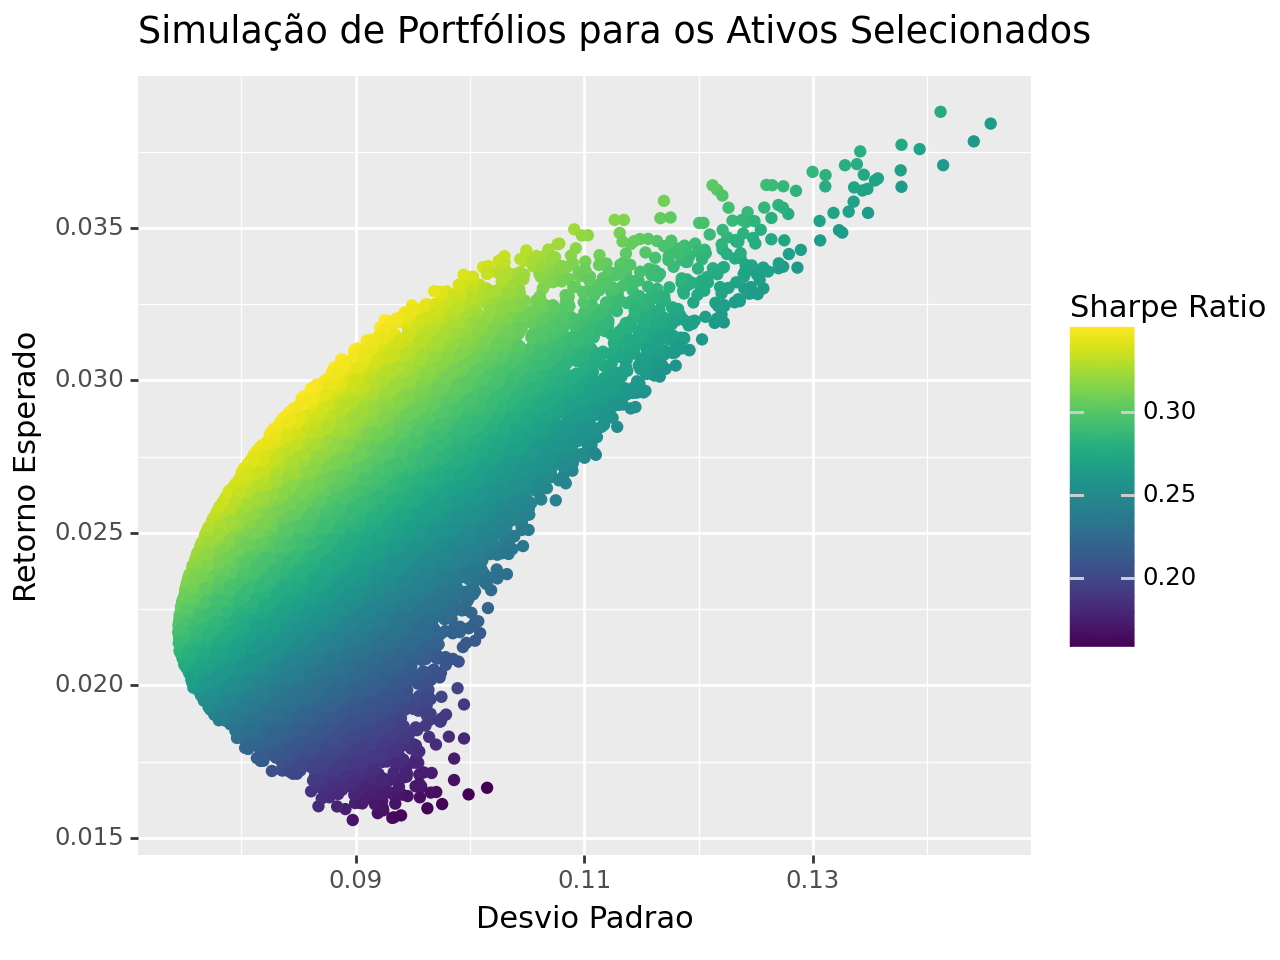

<Figure Size: (640 x 480)>

In [18]:
# calcula o retorno esperado
mu = Y.mean()
# calcula a matriz de covariância
cov_matrix = Y.cov()

# número de portfólio (número de pesos aleatórios gerados)
num_portfolios = 25000

# cria um array para manter os resultados
results = np.zeros((3,num_portfolios))

# cria o for loop para as simulações
for i in range(num_portfolios):
  # seleciona pesos aleatórios para os portfólios
  weights = np.random.random(len(assets))

  # verifica se os portfólios somam 1
  weights /= np.sum(weights)

  # calcula os retornos esperado do portfólio
  portfolio_return = np.sum(mu * weights)
  # calcula a volatilidade
  portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

  # armazena os valores no array
  results[0,i] = portfolio_return
  results[1,i] = portfolio_std_dev

  # Calcula o Sharpe Ratio (retorno / volatilidade) - sem ta>
  results[2,i] = results[0,i] / results[1,i]

# Converte o resultado para um df
results_frame = pd.DataFrame(results.T, columns = ['Retorno Esperado', 'Desvio Padrao', 'Sharpe Ratio'])


# Cria o gráfico de dispersão com barra para o Sharpe
(ggplot(results_frame, aes(x = 'Desvio Padrao', y = 'Retorno Esperado', color = 'Sharpe Ratio'))
+ geom_point()
+ labs(title = "Simulação de Portfólios para os Ativos Selecionados")

)

#----------------------------------------------------------------------------------------------#


## 3. OTIMIZAÇÃO DE CARTEIRA COM **RISKFOLIO**

In [ ]:
# Instala e carrega a biblioteca
!pip install riskfolio-lib
import riskfolio as rp

#----------------------------------------------------------------------------------------------#


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.8/238.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


### 3.1 CARTEIRA DE MÍNIMA VARIÂNCIA

In [ ]:
# Construindo o objeto de portfólio
port = rp.Portfolio(returns = Y)

# Calculando o portfólio ótimo
# Selecionar método e estimar parâmetros de entrada:
method_mu = 'hist' # Método para estimar retornos esperados com base em dados históricos.
method_cov = 'hist' # Método para estimar a matriz de covariancia com base em dados historicos.

# Cria os inputs
port.assets_stats(method_mu = method_mu, method_cov = method_cov)

# Estimando o portfólio ótimo:
model = 'Classic' # Pode ser Classic (histórico), BL (Black Litterman) ou FM (Modelo de Fatores)
rm = 'MV' # Medida de risco usada, mean-variance. Ha possibilidade de diversas outras medidas de risco, checar documentacao.
obj = 'MinRisk' # Funcão objetivo, pode ser MinRisk, MaxRet, Utility ou Sharpe
hist = True # Usar cenários históricos para medidas de risco que dependem de cenários
rf = 0.0 # Taxa livre de risco
l = 0.0 # Fator de aversão ao risco, útil apenas quando obj é 'Utility'

# Otimização do portfólio
w = port.optimization(model = model, rm = rm, obj = obj, rf = rf, l = l, hist = hist)

# Verifica os pesos
display(w.T)

#----------------------------------------------------------------------------------------------#


,BBDC4.SA,ITSA4.SA,GGBR4.SA,WEGE3.SA
weights,18.8205%,0.0000%,33.2371%,47.9424%


In [ ]:
# Gerando a fronteira eficiente
points = 50 # Número de pontos da fronteira

# Cria a variável da fronteira
frontier = port.efficient_frontier(model = model, rm = rm, points = points, rf = rf, hist = hist)

# Verifica as combinações
display(frontier.T.head())

#----------------------------------------------------------------------------------------------#


,BBDC4.SA,ITSA4.SA,GGBR4.SA,WEGE3.SA
0,18.8205%,0.0000%,33.2371%,47.9424%
1,23.0618%,5.8919%,14.7447%,56.3016%
2,23.9454%,9.7755%,7.2800%,58.9991%
3,24.6559%,12.8518%,1.3508%,61.1416%
4,21.8305%,15.8898%,0.0000%,62.2797%


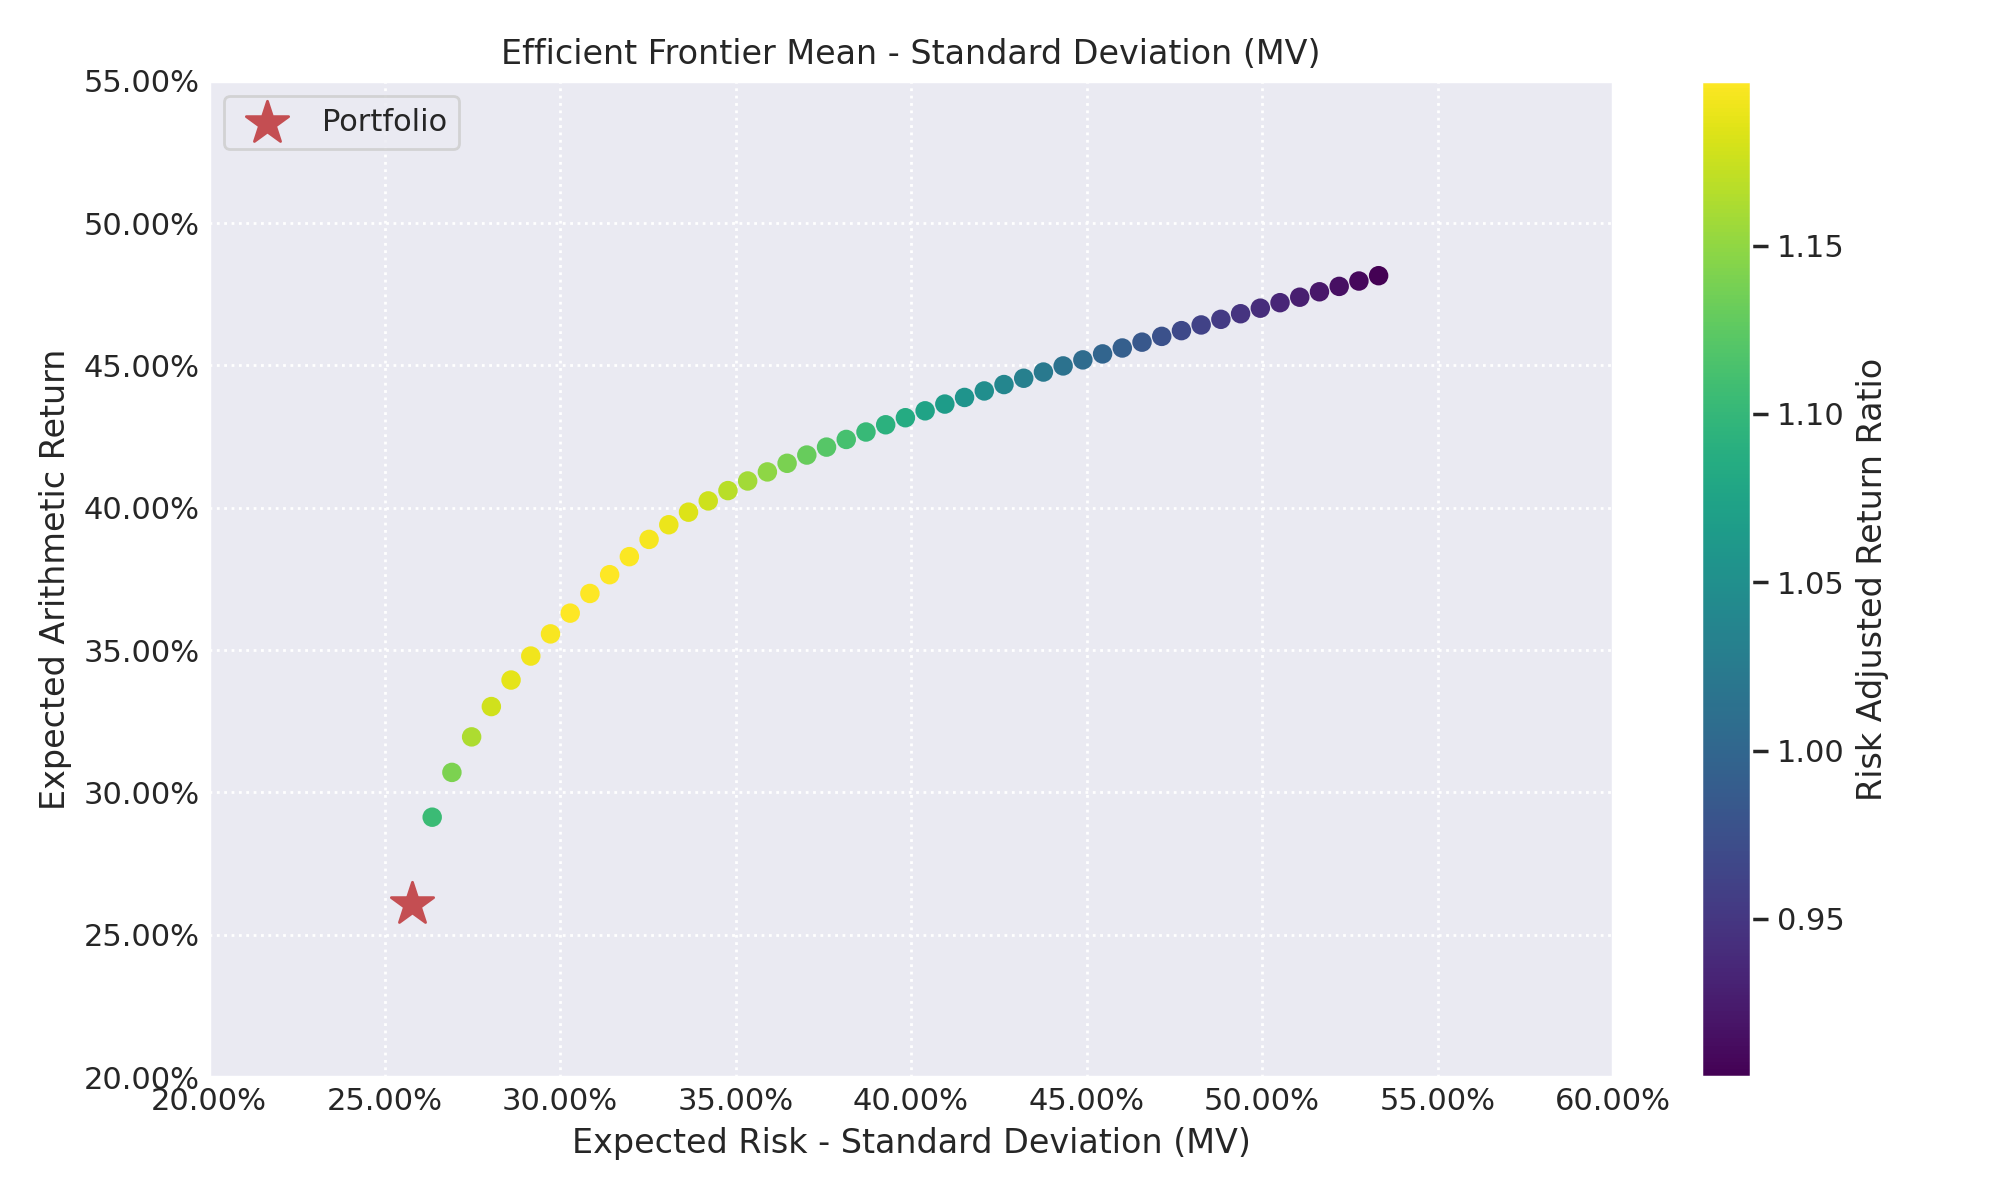

In [ ]:
# Plotando a fronteira eficiente
mu = port.mu # Retorno Esperado
cov = port.cov # Matriz de Covariância
returns = port.returns # Retorno dos ativos

# Cria o gráfico
ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, s=16, c='r', height=6, width=10, ax=None, t_factor=12)

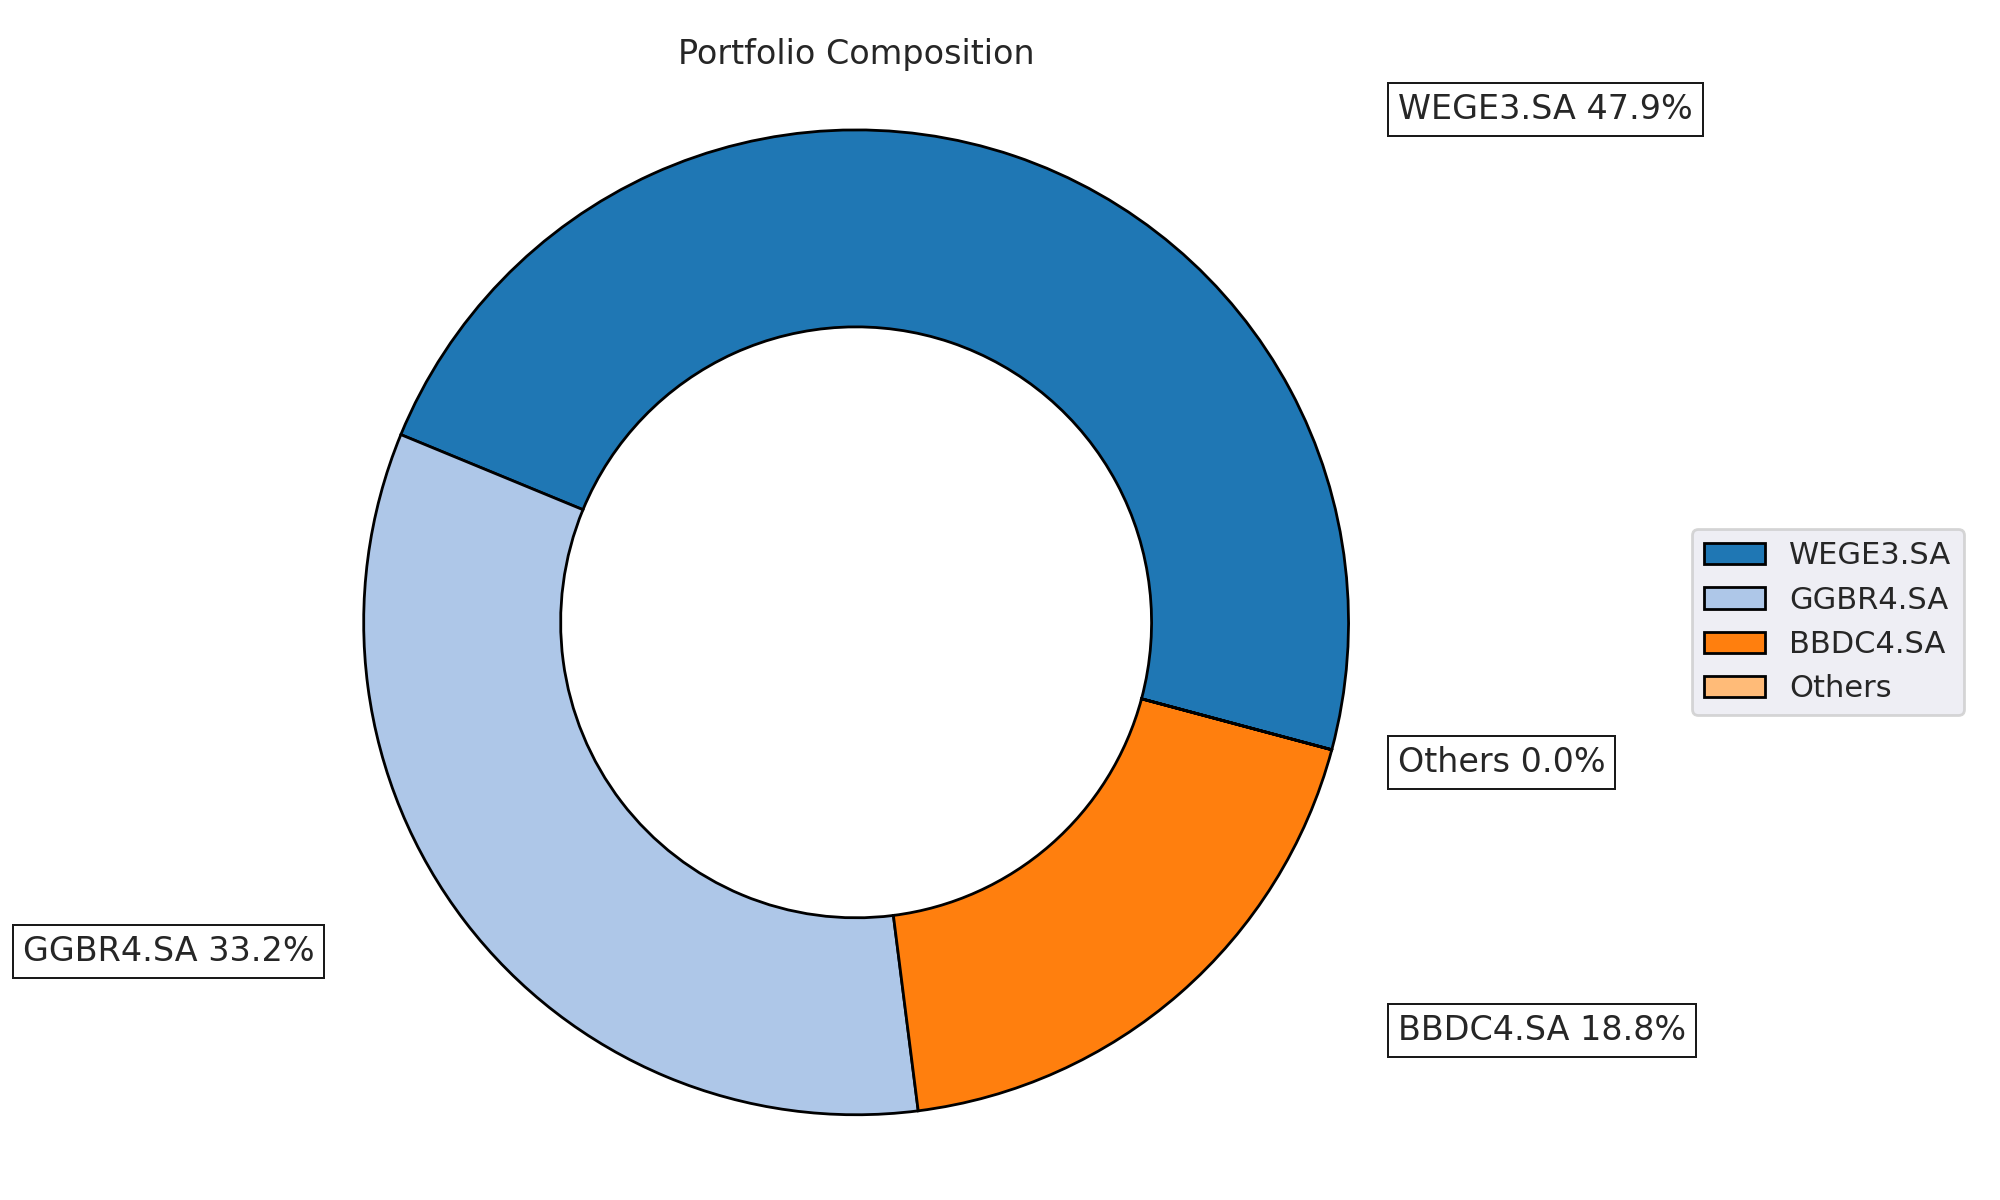

In [ ]:
# Plota a composição do Portfólio
ax = rp.plot_pie(w = w, others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

#### 3.2 ANALISE DE PORTIFÓLIO AJUSTADO AO mÁXIMO RETORNO

In [ ]:
# Construindo o objeto de portfólio
port = rp.Portfolio(returns = Y)

# Calculando o portfólio ótimo
# Selecionar método e estimar parâmetros de entrada:
method_mu = 'hist' # Método para estimar retornos esperados com base em dados históricos.
method_cov = 'hist' # Método para estimar a matriz de covariancia com base em dados historicos.

# Cria os inputs
port.assets_stats(method_mu = method_mu, method_cov = method_cov)

# Estimando o portfólio ótimo:
model = 'Classic' # Pode ser Classic (histórico), BL (Black Litterman) ou FM (Modelo de Fatores)
rm = 'MV' # Medida de risco usada, mean-variance. Ha possibilidade de diversas outras medidas de risco, checar documentacao.
obj = 'MaxRet' # Funcão objetivo, pode ser MinRisk, MaxRet, Utility ou Sharpe
hist = True # Usar cenários históricos para medidas de risco que dependem de cenários
rf = 0.0 # Taxa livre de risco
l = 0.0 # Fator de aversão ao risco, útil apenas quando obj é 'Utility'

# Otimização do portfólio
w = port.optimization(model = model, rm = rm, obj = obj, rf = rf, l = l, hist = hist)

# Verifica os pesos
display(w.T)

#----------------------------------------------------------------------------------------------#


,BBDC4.SA,ITSA4.SA,GGBR4.SA,WEGE3.SA
weights,0.0000%,100.0000%,0.0000%,0.0000%


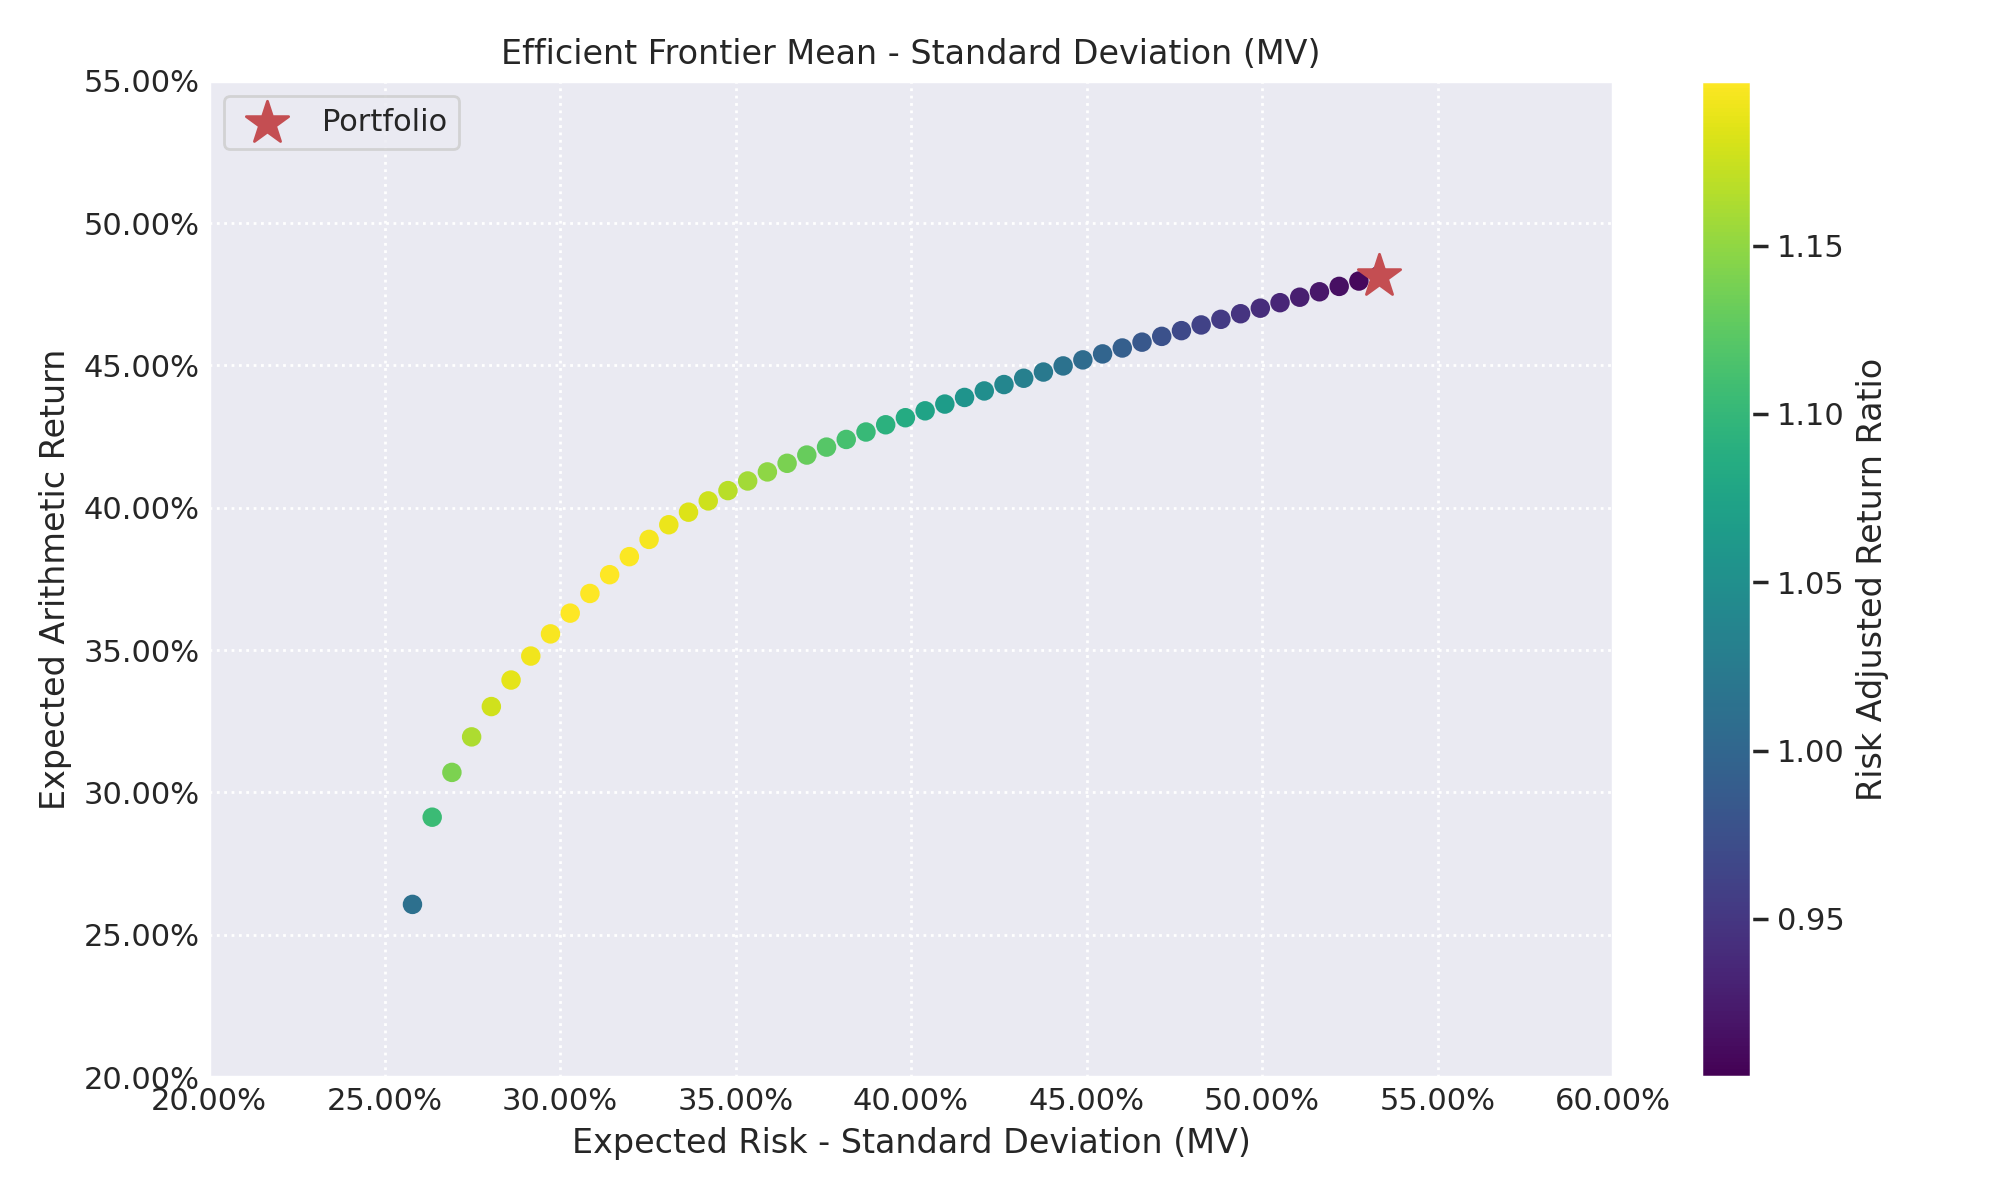

In [ ]:
# Plotando a fronteira eficiente
mu = port.mu # Retorno Esperado
cov = port.cov # Matriz de Covariância
returns = port.returns # Retorno dos ativos

# Cria o gráfico
ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, s=16, c='r', height=6, width=10, ax=None, t_factor=12)

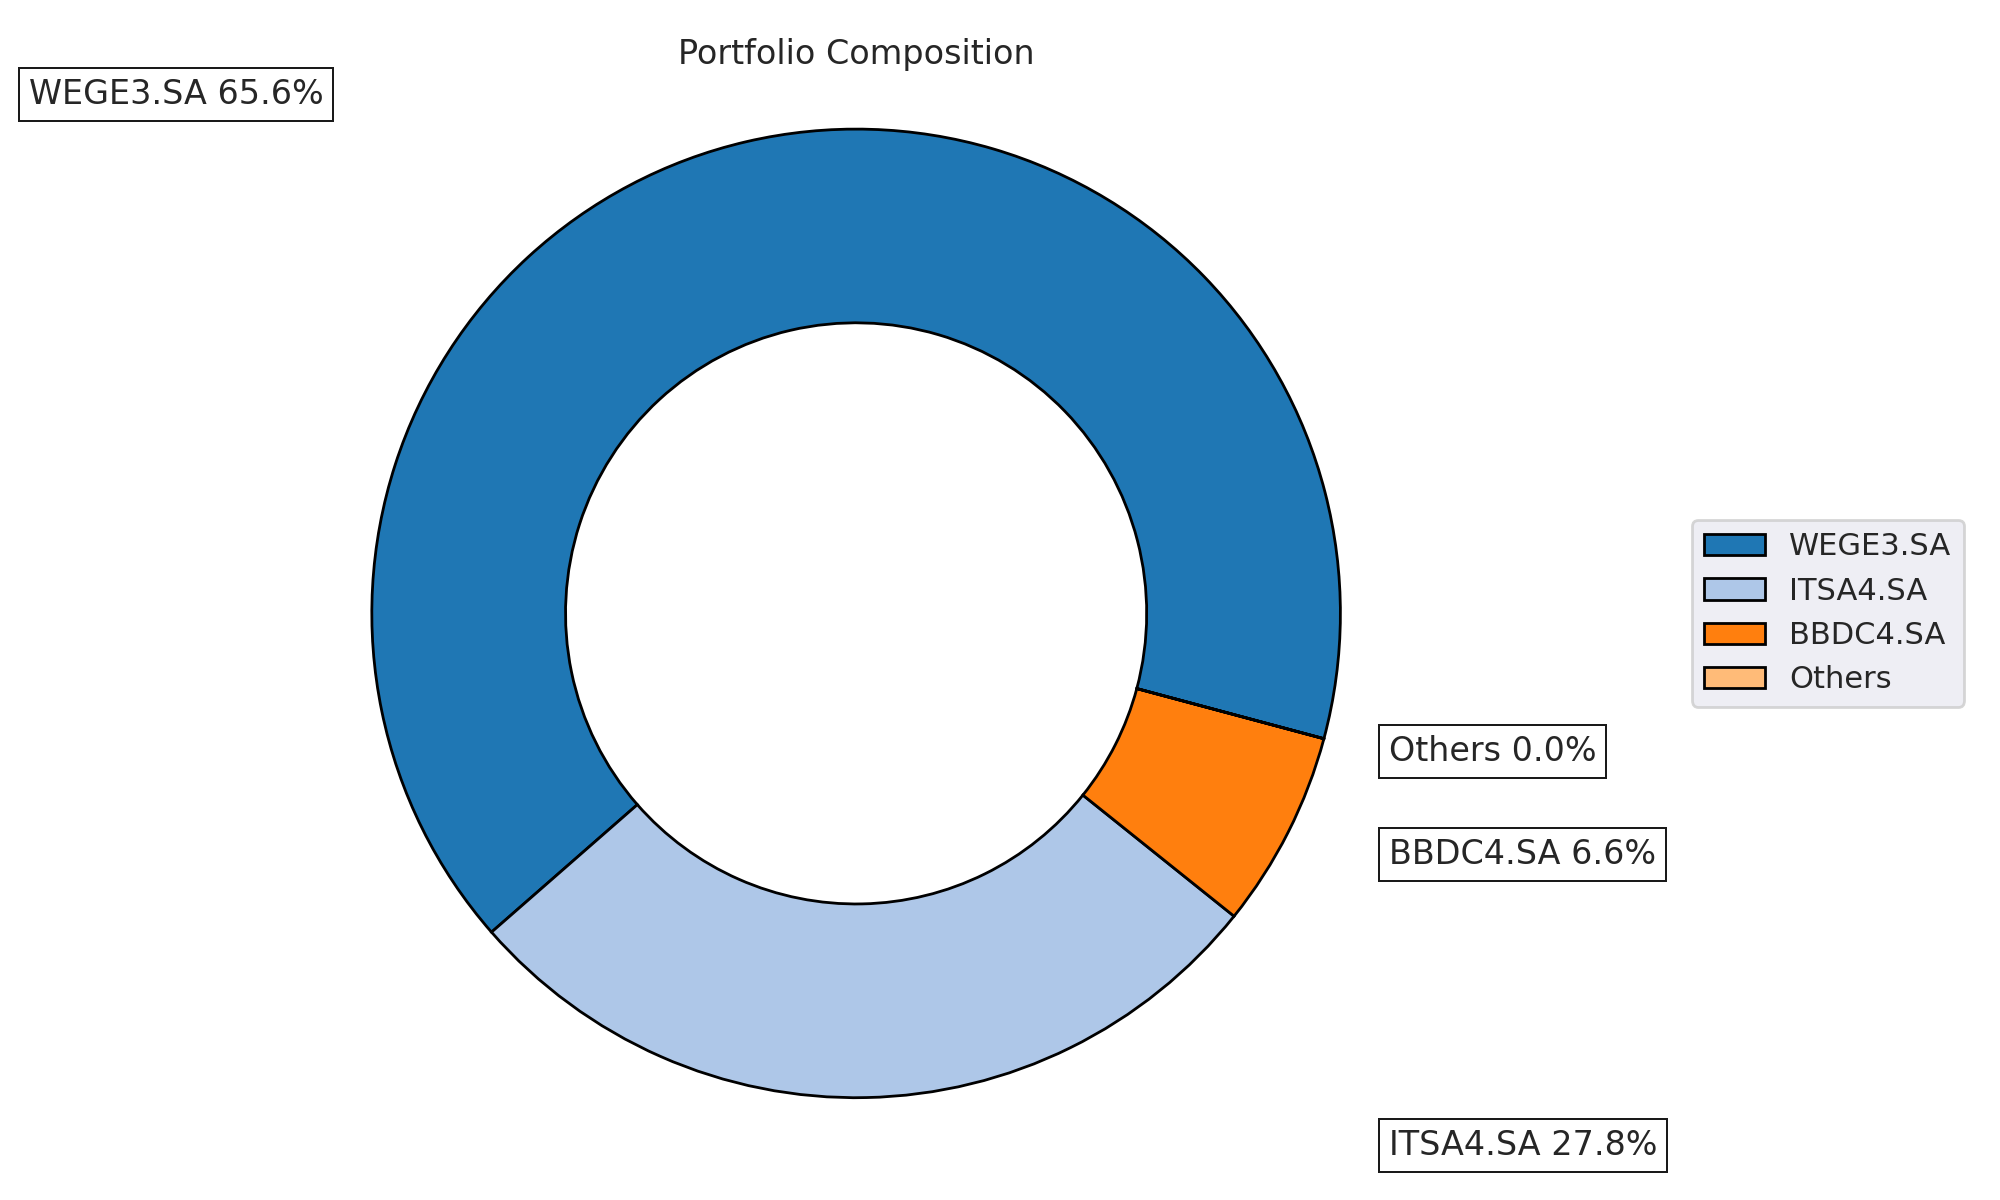

In [ ]:
# Plota a composição do Portfólio
ax = rp.plot_pie(w = w, others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

#### 3.3 ANALISE DE PORTIFÓLIO AJUSTADO A TAXA DE RISCO AJUSTADO AO RETORNO

In [ ]:
# Construindo o objeto de portfólio
port = rp.Portfolio(returns = Y)

# Calculando o portfólio ótimo
# Selecionar método e estimar parâmetros de entrada:
method_mu = 'hist' # Método para estimar retornos esperados com base em dados históricos.
method_cov = 'hist' # Método para estimar a matriz de covariancia com base em dados historicos.

# Cria os inputs
port.assets_stats(method_mu = method_mu, method_cov = method_cov)

# Estimando o portfólio ótimo:
model = 'Classic' # Pode ser Classic (histórico), BL (Black Litterman) ou FM (Modelo de Fatores)
rm = 'MV' # Medida de risco usada, mean-variance. Ha possibilidade de diversas outras medidas de risco, checar documentacao.
obj = 'Sharpe' # Funcão objetivo, pode ser MinRisk, MaxRet, Utility ou Sharpe
hist = True # Usar cenários históricos para medidas de risco que dependem de cenários
rf = 0 # Taxa livre de risco
l = 0 # Fator de aversão ao risco, útil apenas quando obj é 'Utility'

# Otimização do portfólio
w = port.optimization(model = model, rm = rm, obj = obj, rf = rf, l = l, hist = hist)

# Verifica os pesos
display(w.T)

#----------------------------------------------------------------------------------------------#

,BBDC4.SA,ITSA4.SA,GGBR4.SA,WEGE3.SA
weights,6.5840%,27.8149%,0.0000%,65.6011%


In [ ]:
# Gerando a fronteira eficiente
points = 50 # Número de pontos da fronteira

# Cria a variável da fronteira
frontier = port.efficient_frontier(model = model, rm = rm, points = points, rf = rf, hist = hist)

# Verifica as combinações
display(frontier.T.head())

#----------------------------------------------------------------------------------------------#


,BBDC4.SA,ITSA4.SA,GGBR4.SA,WEGE3.SA
0,18.8205%,0.0000%,33.2371%,47.9424%
1,23.0618%,5.8919%,14.7447%,56.3016%
2,23.9454%,9.7755%,7.2800%,58.9991%
3,24.6559%,12.8518%,1.3508%,61.1416%
4,21.8305%,15.8898%,0.0000%,62.2797%


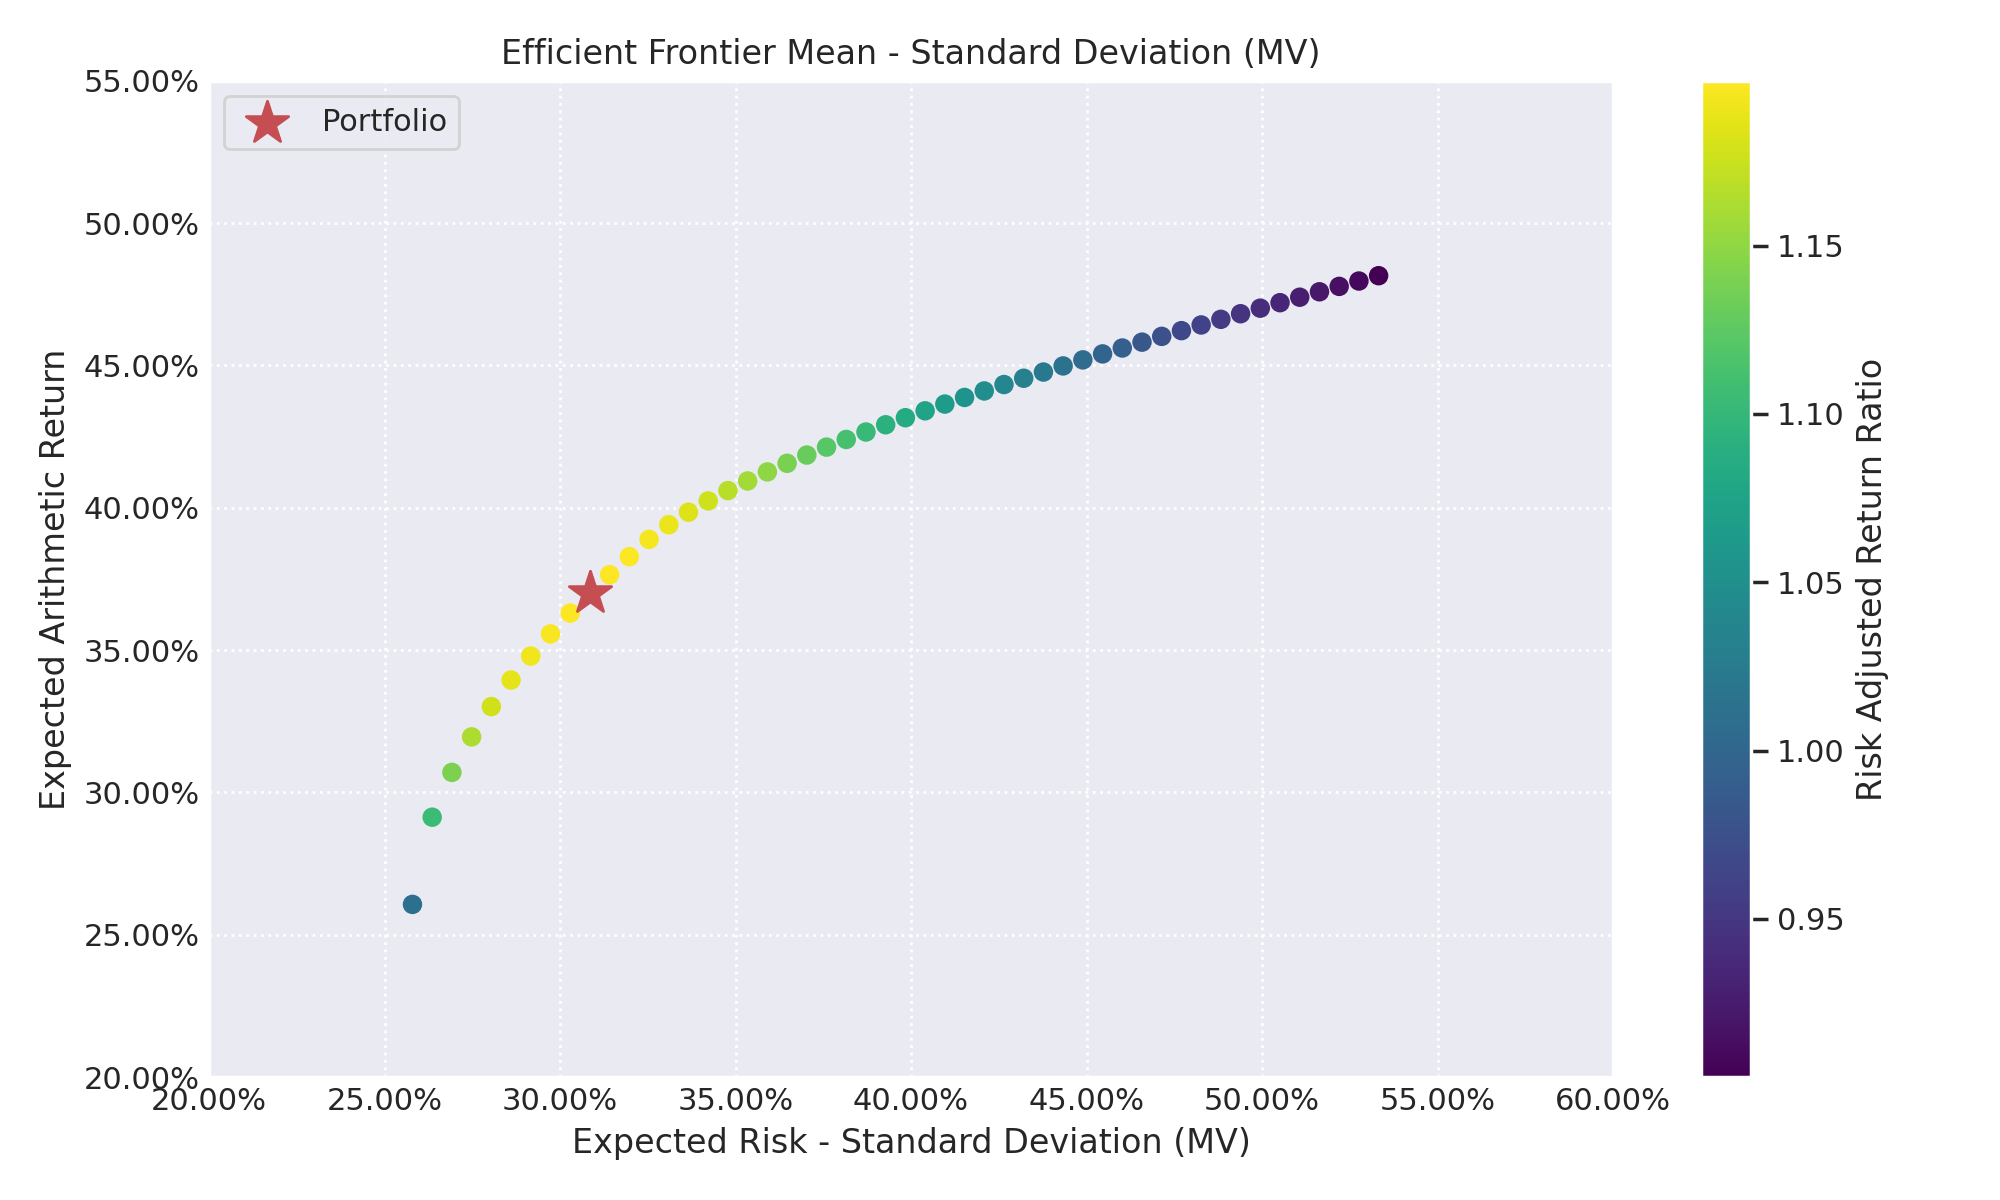

In [ ]:
# Plotando a fronteira eficiente
mu = port.mu # Retorno Esperado
cov = port.cov # Matriz de Covariância
returns = port.returns # Retorno dos ativos

# Cria o gráfico
ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, s=16, c='r', height=6, width=10, ax=None, t_factor=12)

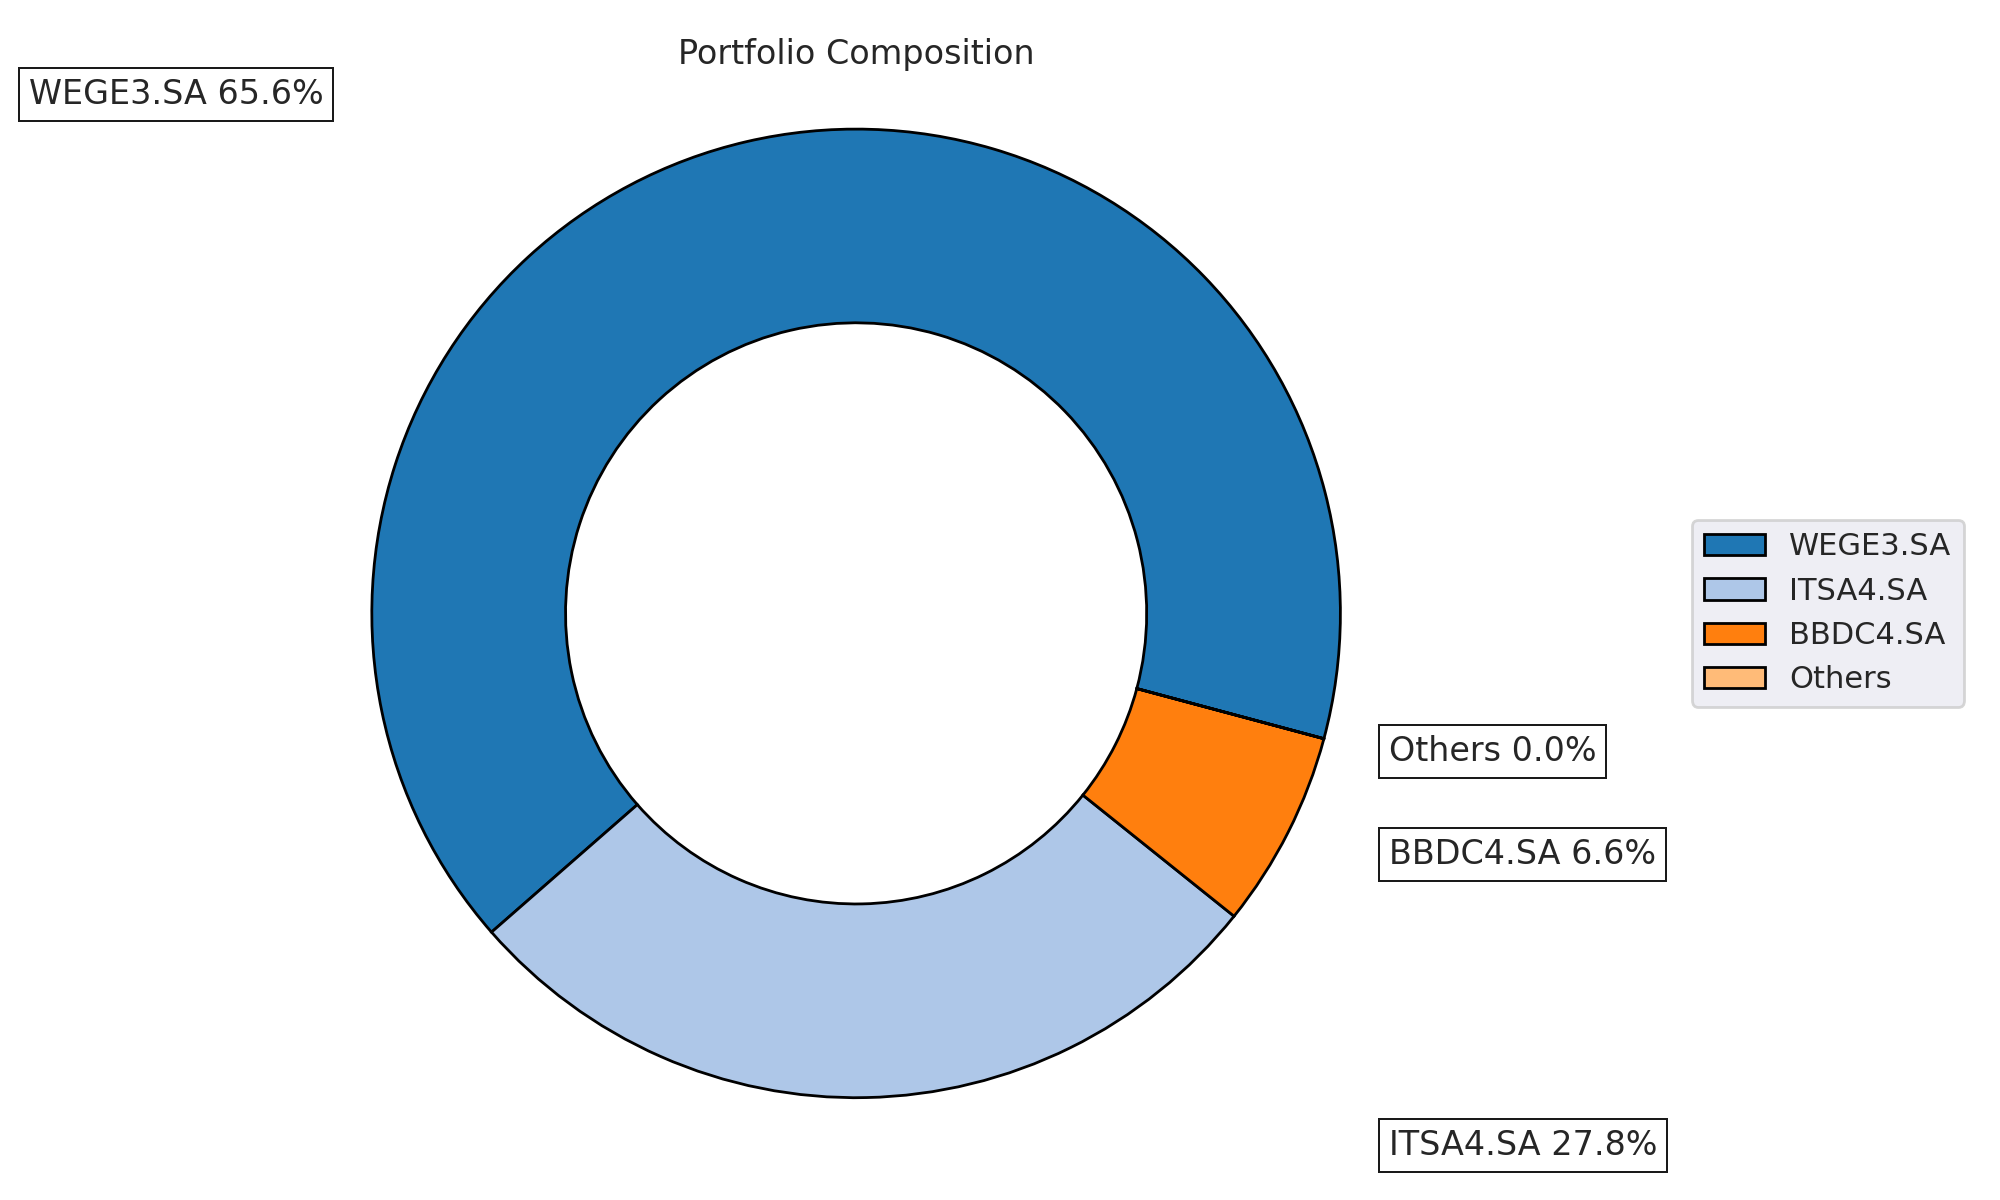

In [ ]:
# Plota a composição do Portfólio
ax = rp.plot_pie(w = w, others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.4 CARTEIRA DE MÁXIMA UTILIDADE

In [ ]:
# Construindo o objeto de portfólio
port = rp.Portfolio(returns = Y)

# Calculando o portfólio ótimo
# Selecionar método e estimar parâmetros de entrada:
method_mu = 'hist' # Método para estimar retornos esperados com base em dados históricos.
method_cov = 'hist' # Método para estimar a matriz de covariancia com base em dados historicos.

# Cria os inputs
port.assets_stats(method_mu = method_mu, method_cov = method_cov)

# Estimando o portfólio ótimo:
model = 'Classic' # Pode ser Classic (histórico), BL (Black Litterman) ou FM (Modelo de Fatores)
rm = 'MV' # Medida de risco usada, mean-variance. Ha possibilidade de diversas outras medidas de risco, checar documentacao.
obj = 'Utility' # Funcão objetivo, pode ser MinRisk, MaxRet, Utility ou Sharpe
hist = True # Usar cenários históricos para medidas de risco que dependem de cenários
rf = 0 # Taxa livre de risco
l = 0.5 # Fator de aversão ao risco, útil apenas quando obj é 'Utility'

# Otimização do portfólio
w = port.optimization(model = model, rm = rm, obj = obj, rf = rf, l = l, hist = hist)

# Verifica os pesos
display(w.T)

#----------------------------------------------------------------------------------------------#

,BBDC4.SA,ITSA4.SA,GGBR4.SA,WEGE3.SA
weights,0.0000%,68.9503%,0.0000%,31.0497%


In [ ]:
# Gerando a fronteira eficiente
points = 50 # Número de pontos da fronteira

# Cria a variável da fronteira
frontier = port.efficient_frontier(model = model, rm = rm, points = points, rf = rf, hist = hist)

# Verifica as combinações
display(frontier.T.head())

#----------------------------------------------------------------------------------------------#

,BBDC4.SA,ITSA4.SA,GGBR4.SA,WEGE3.SA
0,18.8205%,0.0000%,33.2371%,47.9424%
1,23.0618%,5.8919%,14.7447%,56.3016%
2,23.9454%,9.7755%,7.2800%,58.9991%
3,24.6559%,12.8518%,1.3508%,61.1416%
4,21.8305%,15.8898%,0.0000%,62.2797%


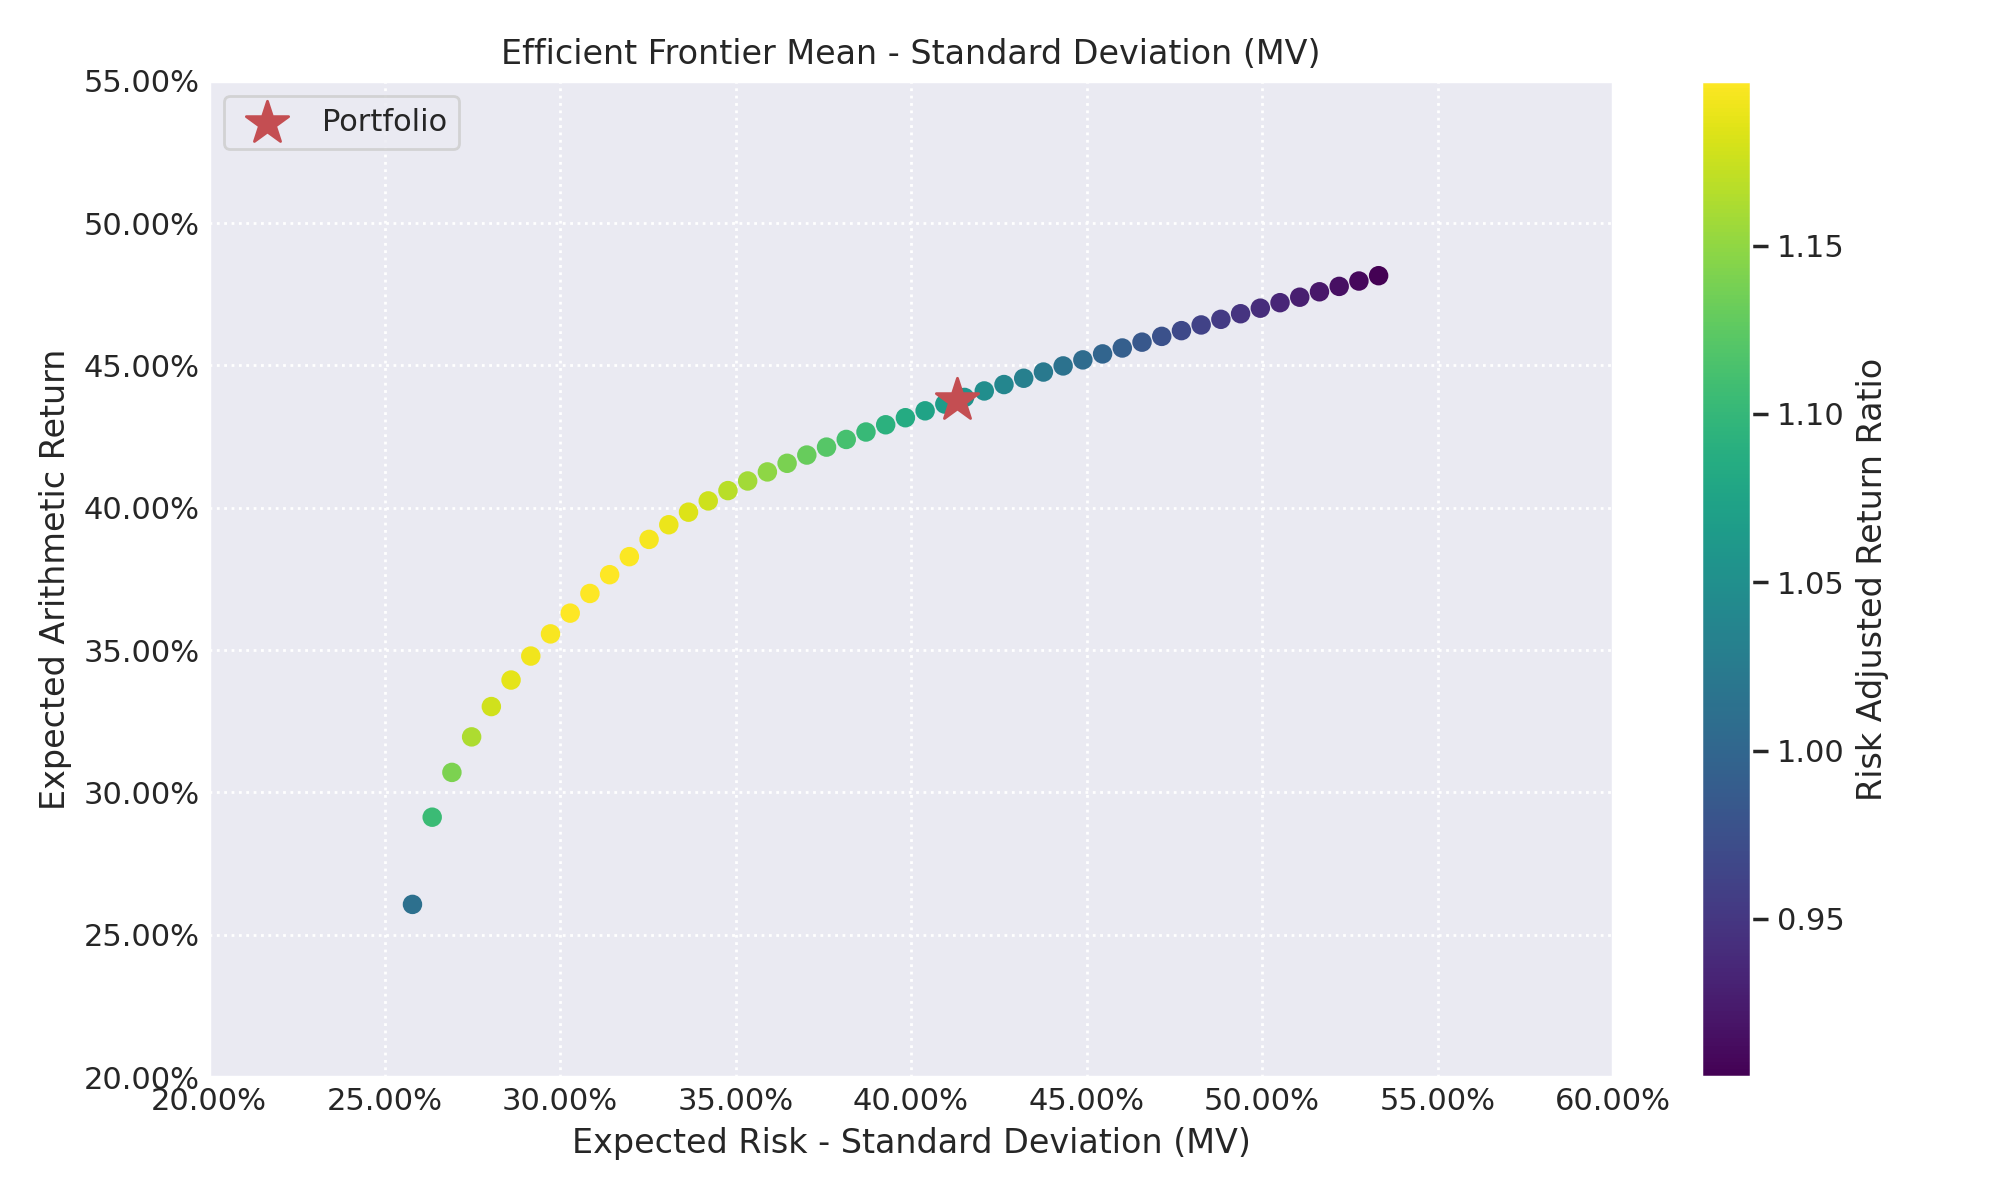

In [ ]:
# Plotando a fronteira eficiente
mu = port.mu # Retorno Esperado
cov = port.cov # Matriz de Covariância
returns = port.returns # Retorno dos ativos

# Cria o gráfico
ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, s=16, c='r', height=6, width=10, ax=None, t_factor=12)

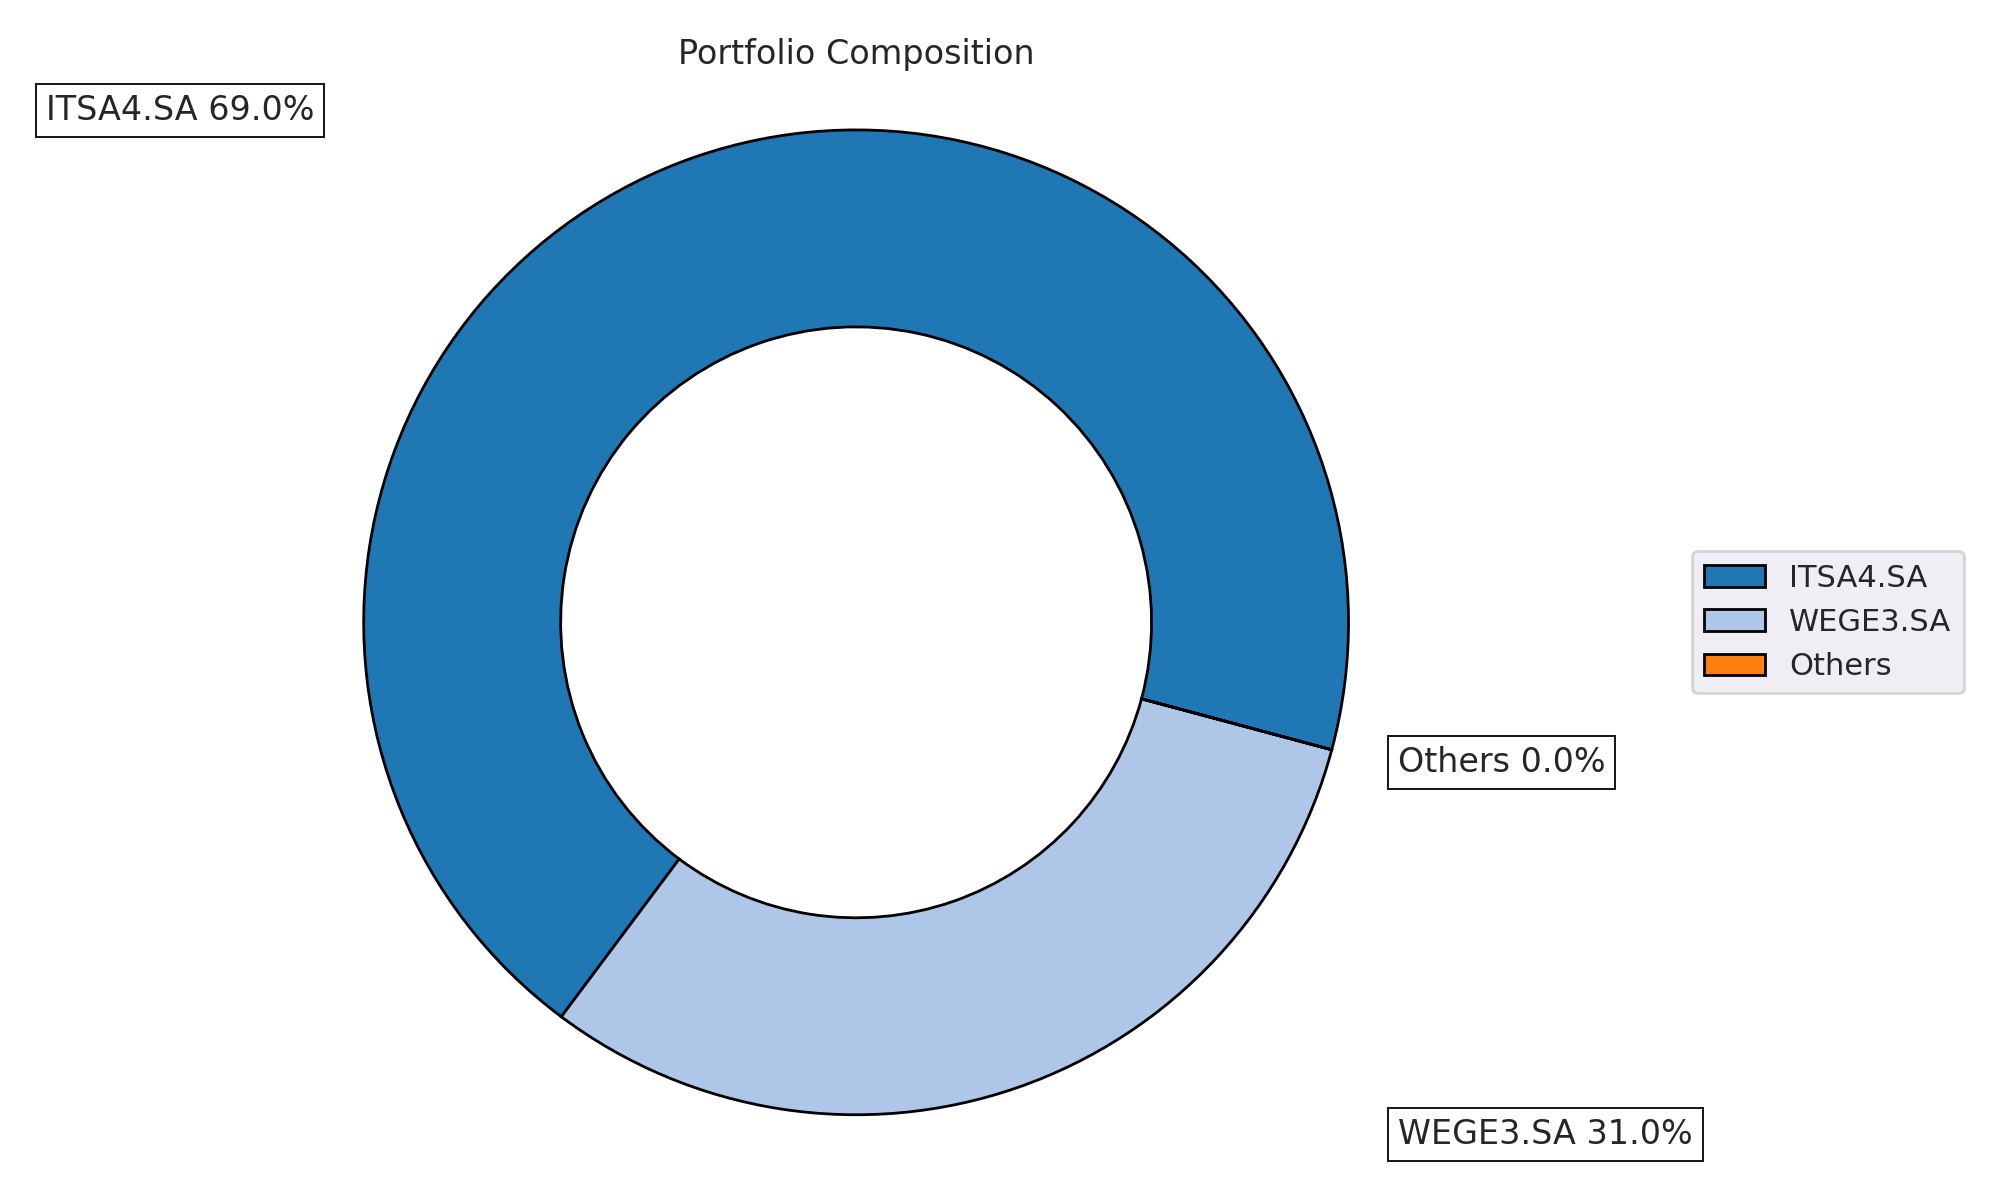

In [ ]:
# Plota a composição do Portfólio
ax = rp.plot_pie(w = w, others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

## 4. GRÁFICOS


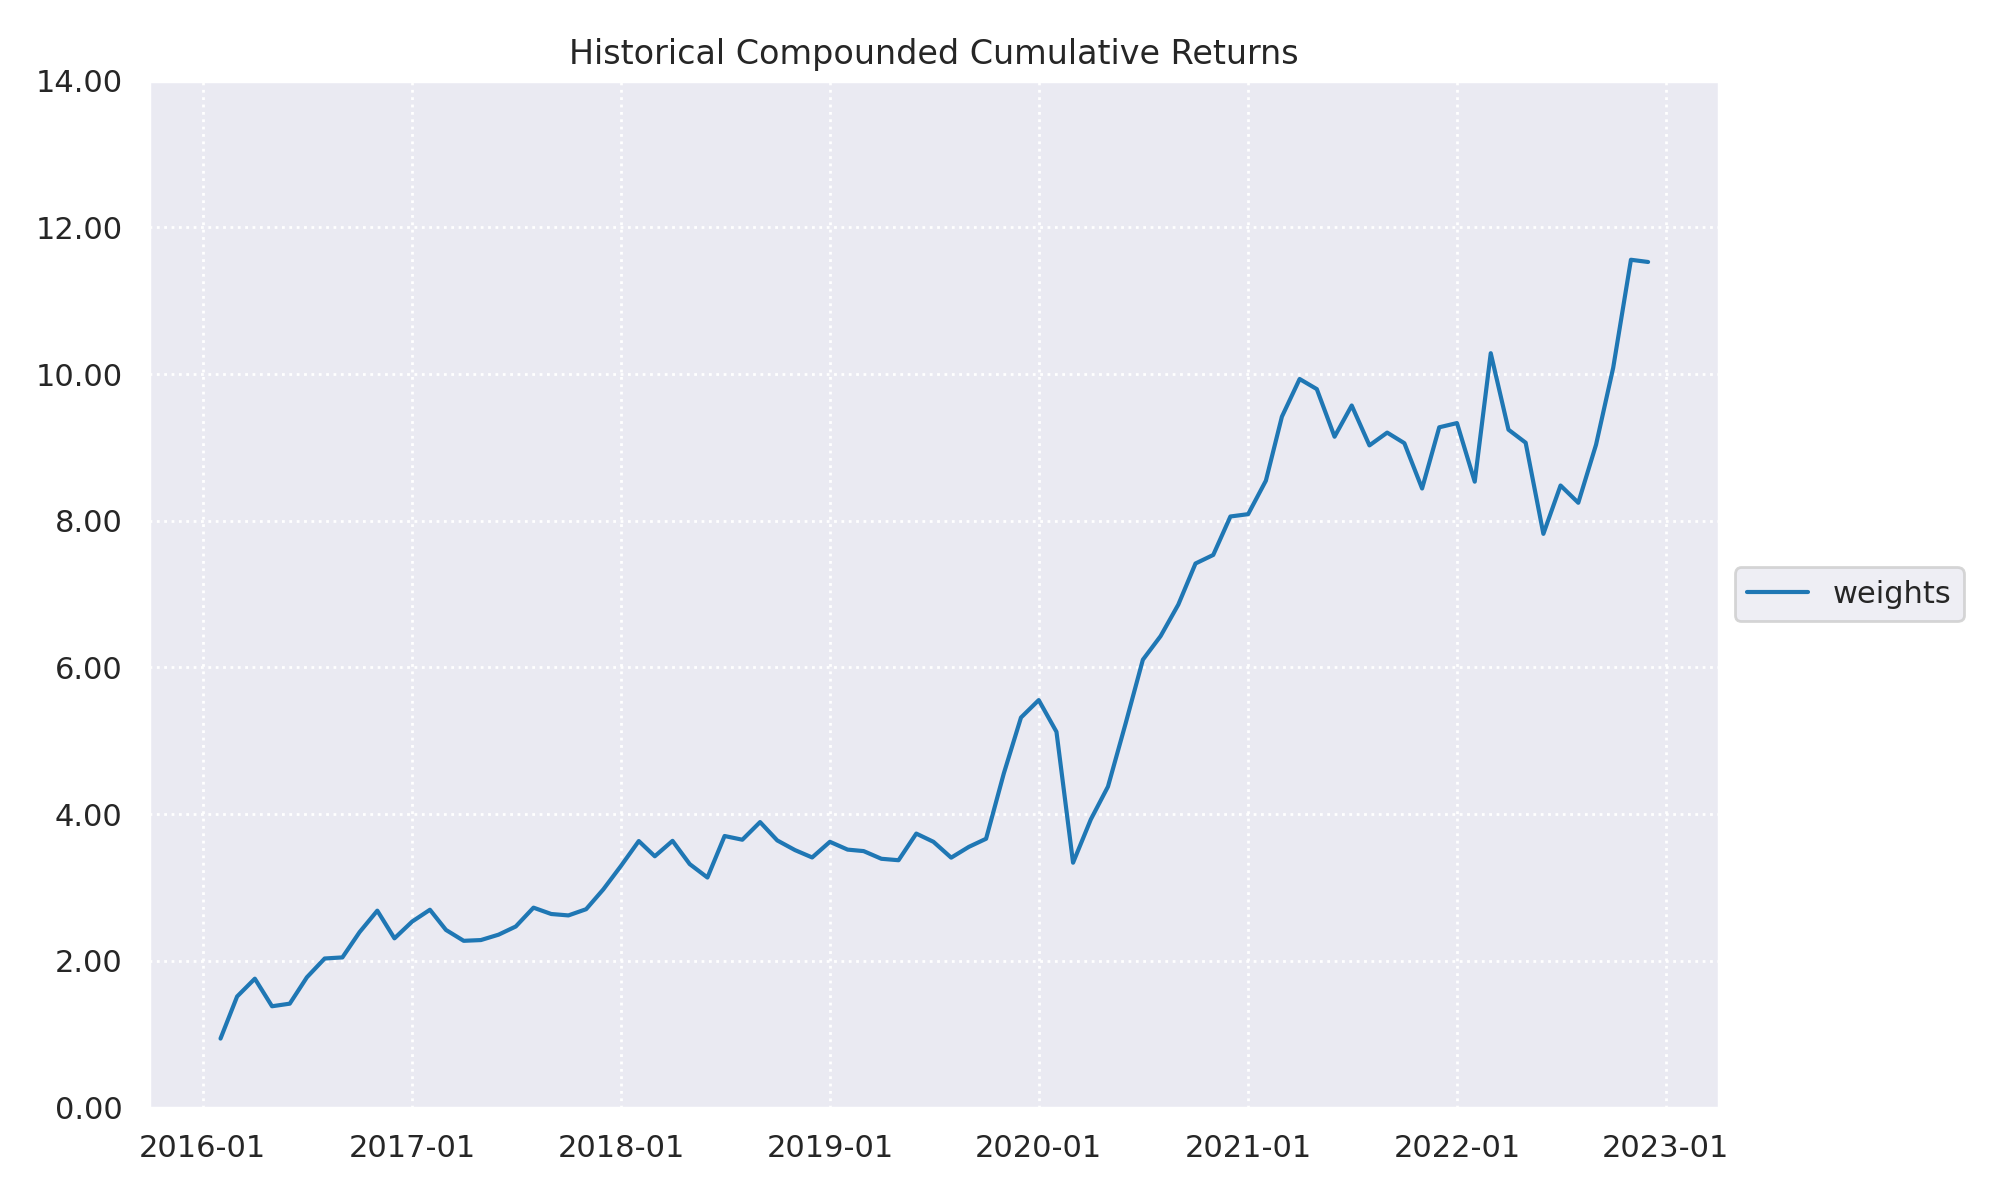

In [ ]:
ax_series = rp.plot_series(returns = Y,
                           w = w,
                           cmap = 'tab20',
                           height = 6,
                           width = 10,
                           ax = None)

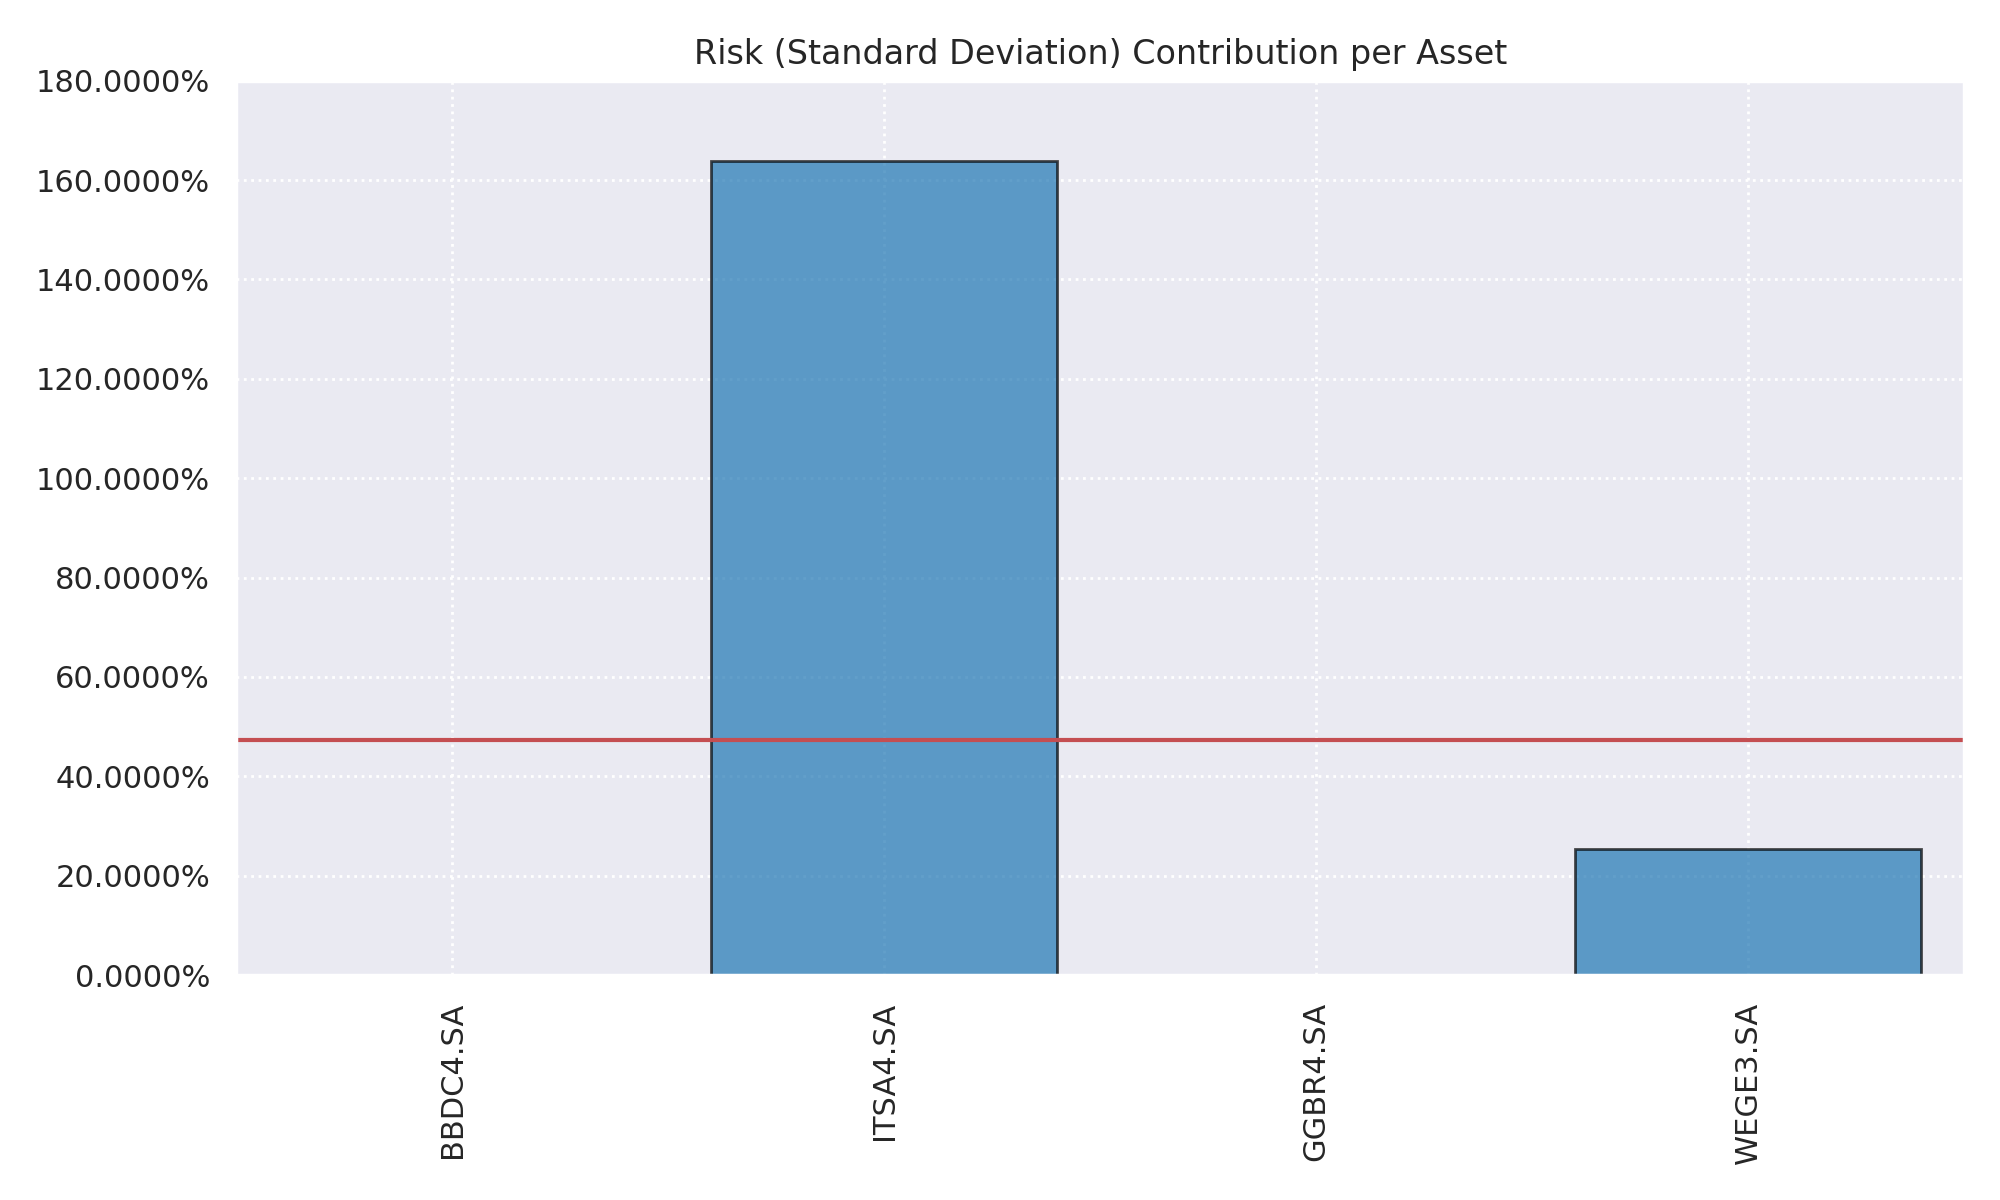

In [ ]:
risk_cont = rp.plot_risk_con(w = w,
                             cov = cov,
                             returns=returns,
                             rm=rm,
                             rf=0,
                             alpha=0.05,
                             color="tab:blue",
                             height = 6,
                             width = 10,
                             t_factor=252,
                             ax = None)

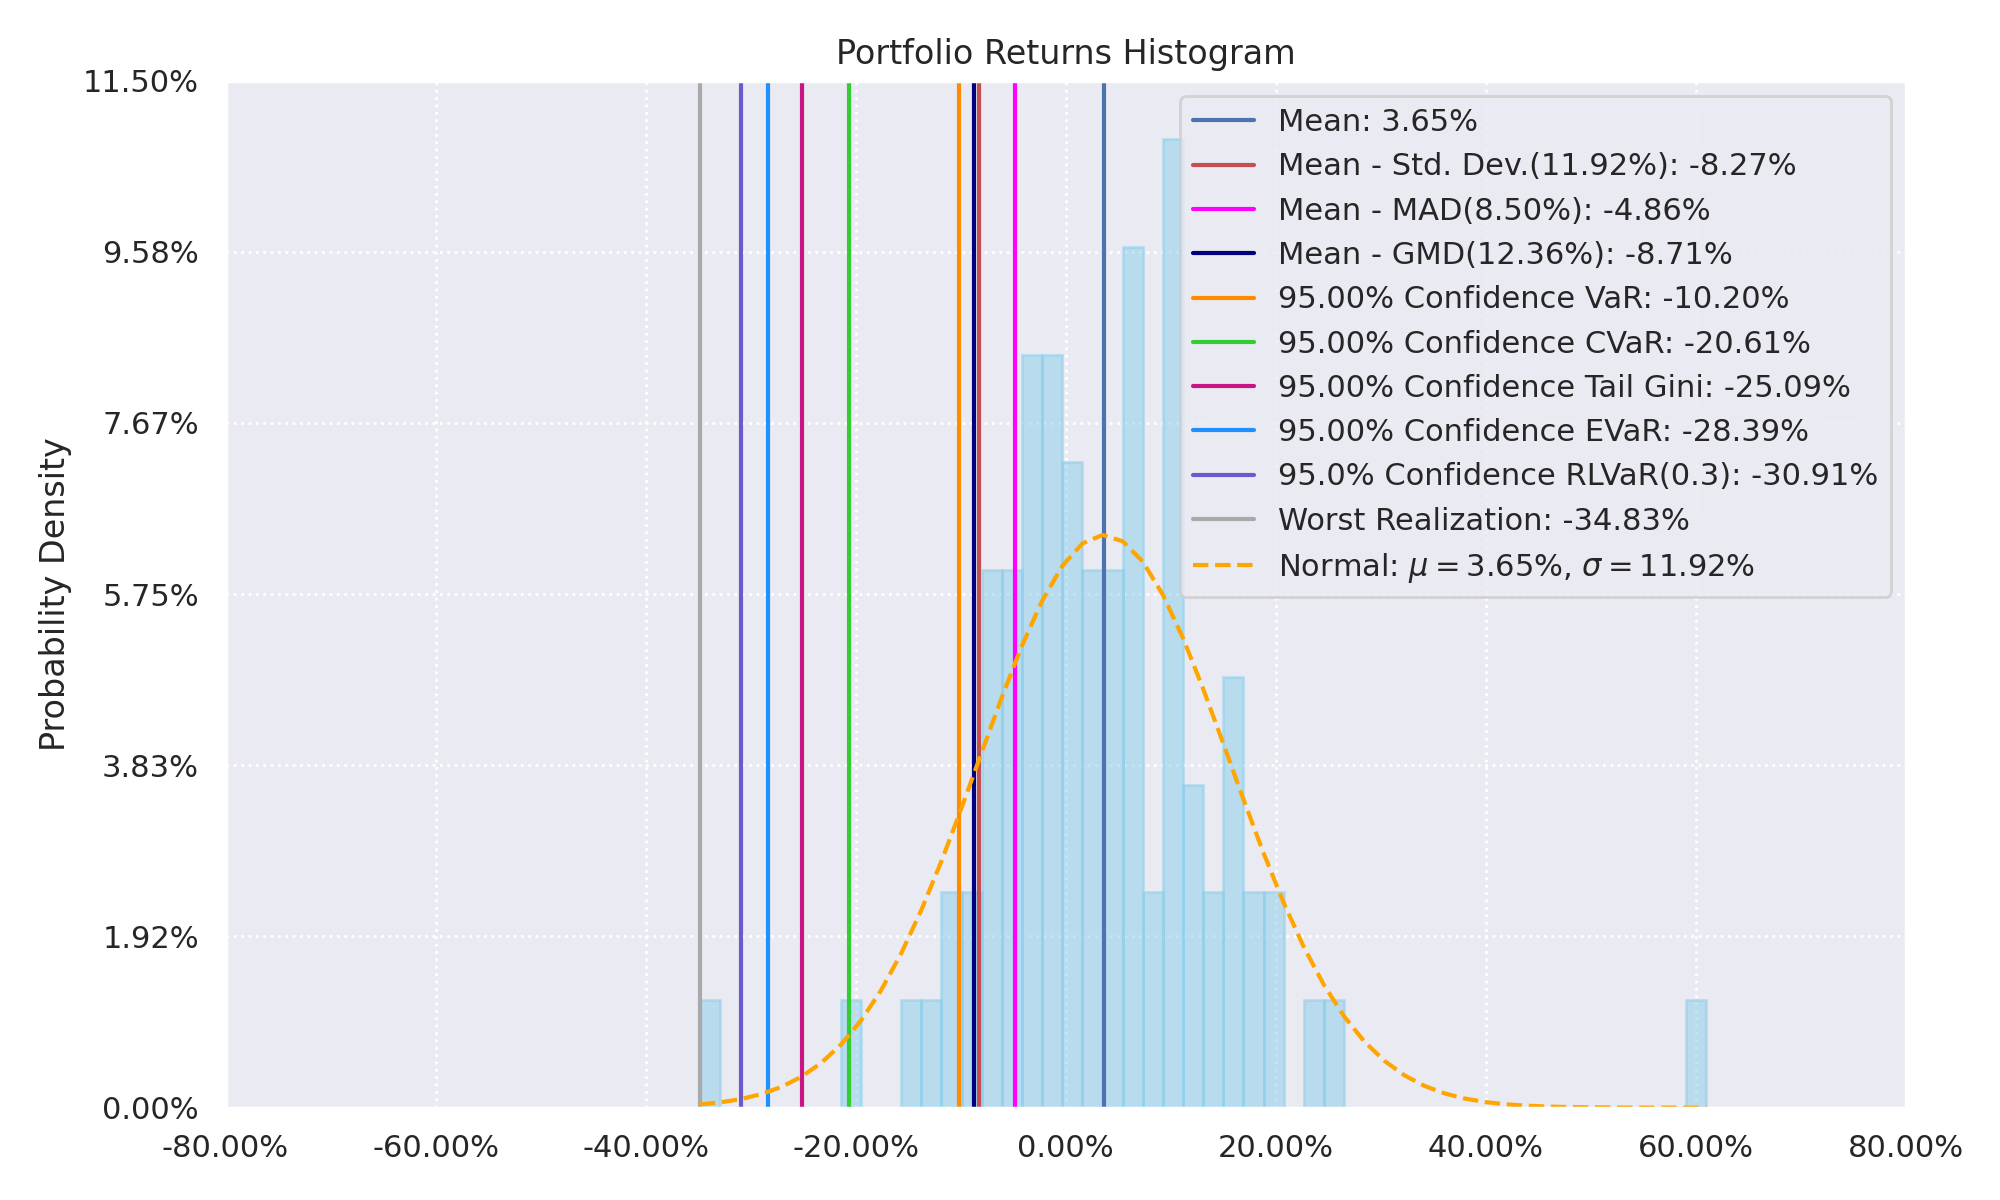

In [ ]:
histogram = rp.plot_hist(returns=Y,
                         w=w,
                         alpha=0.05,
                         bins=50,
                         height=6,
                         width=10,
                         ax=None)

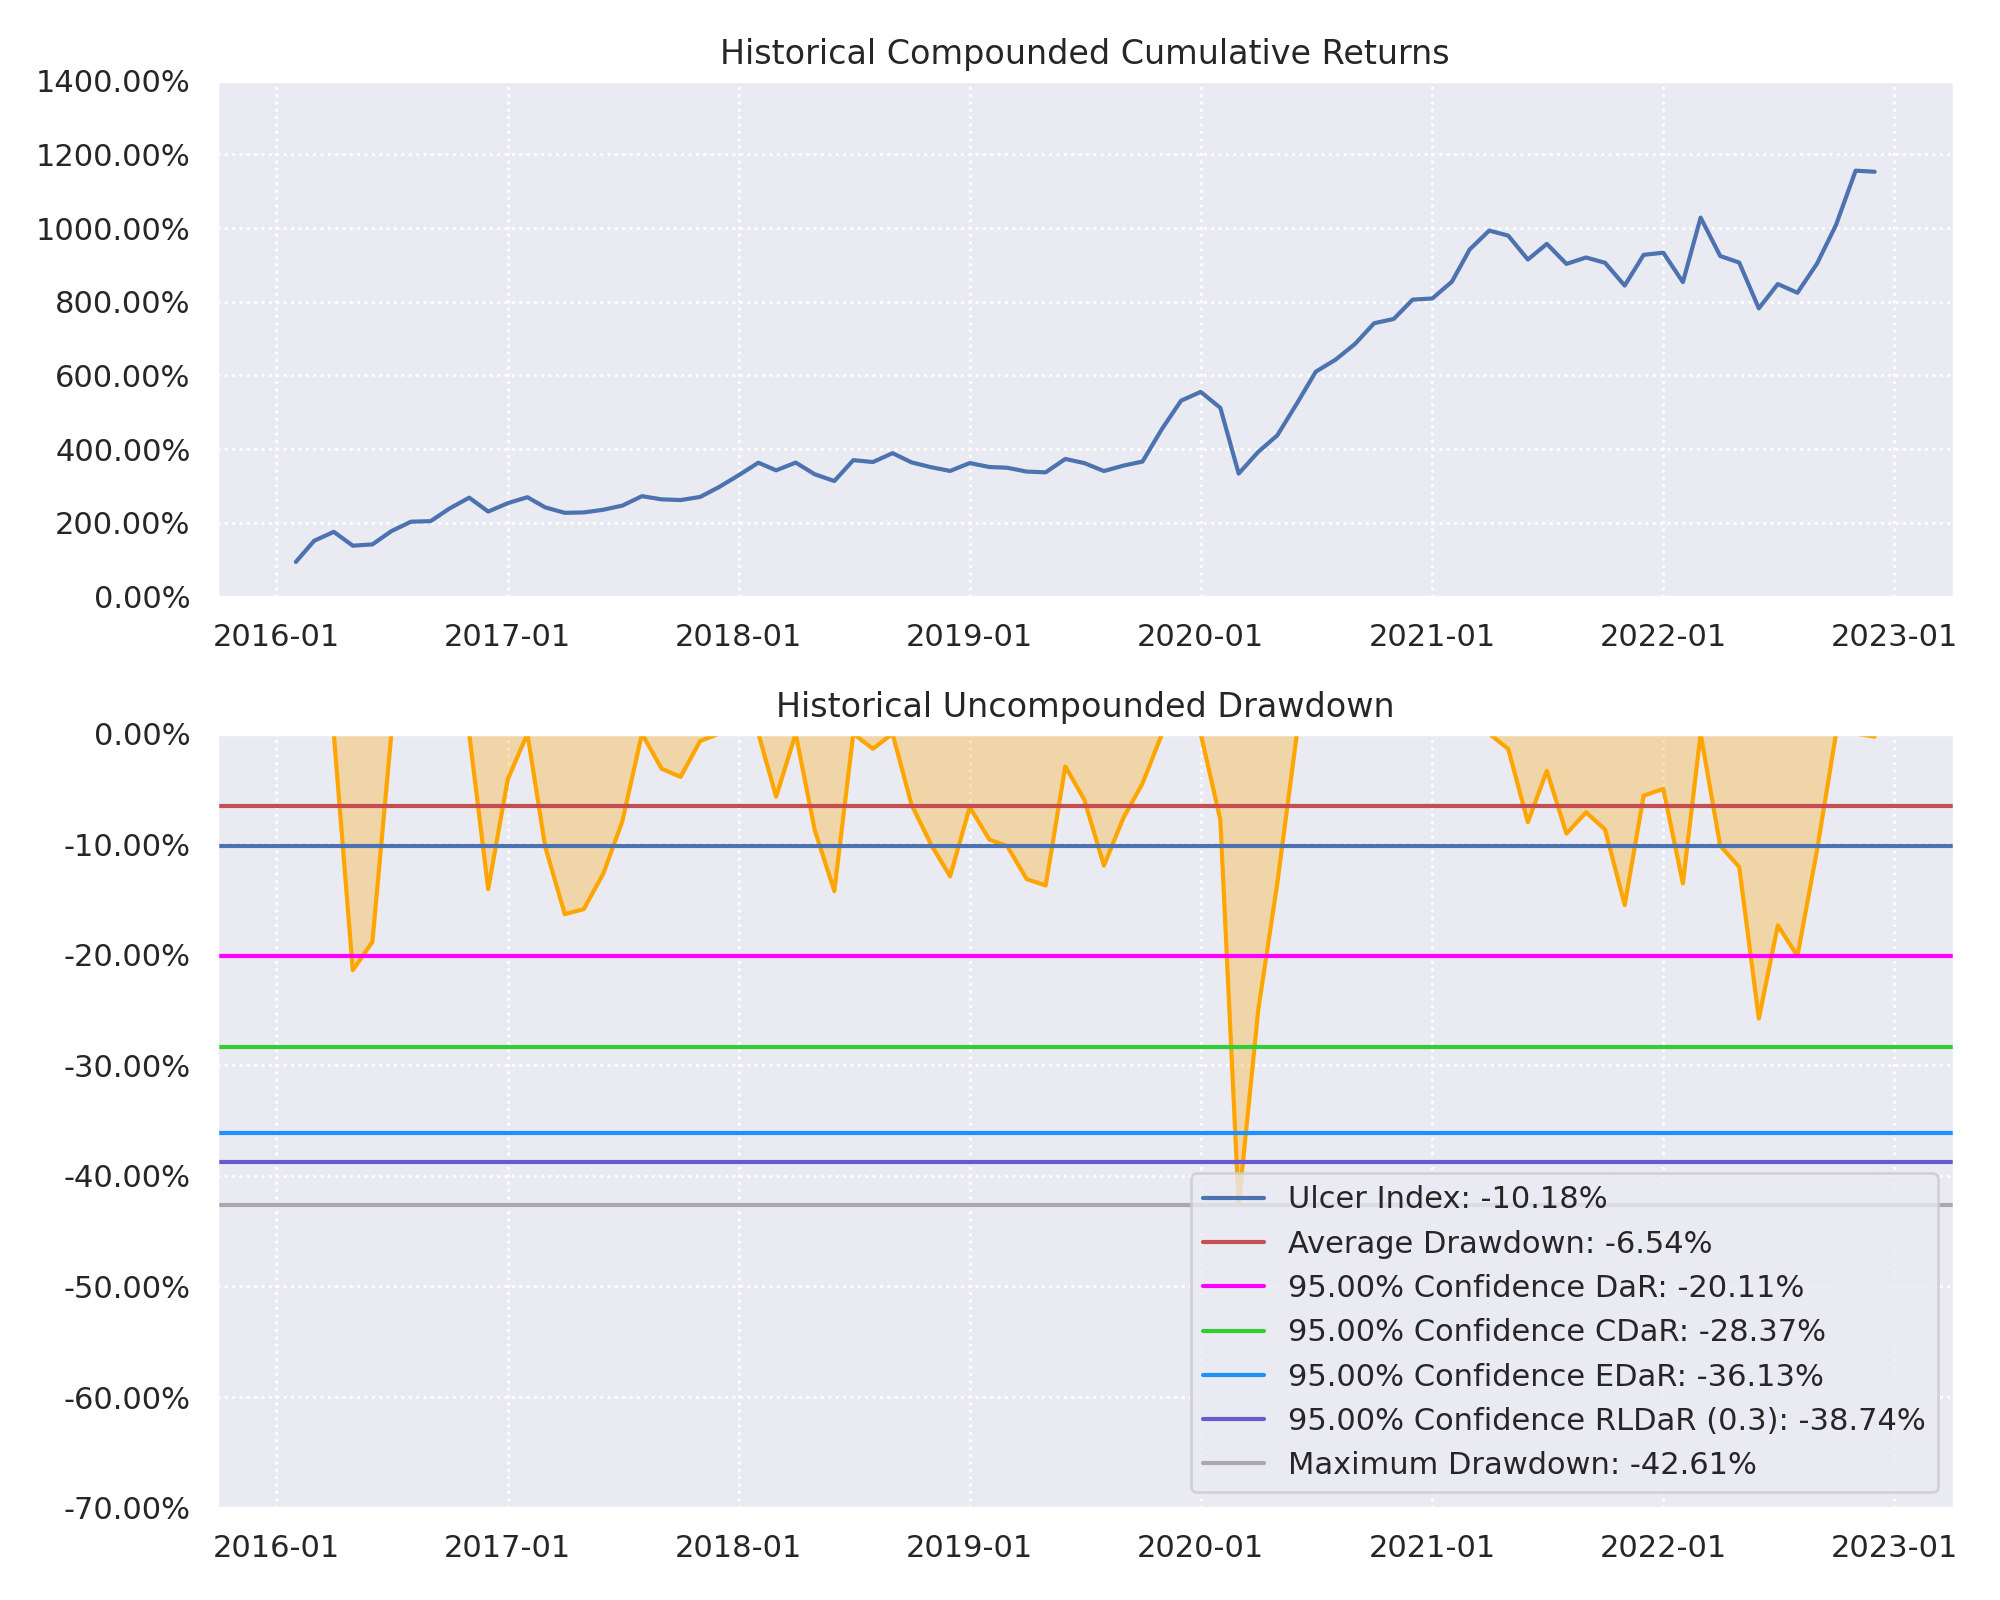

In [ ]:
drawdown = rp.plot_drawdown(returns=Y,
                            w=w,
                            alpha=0.05,
                            height=8,
                            width=10,
                            ax=None)

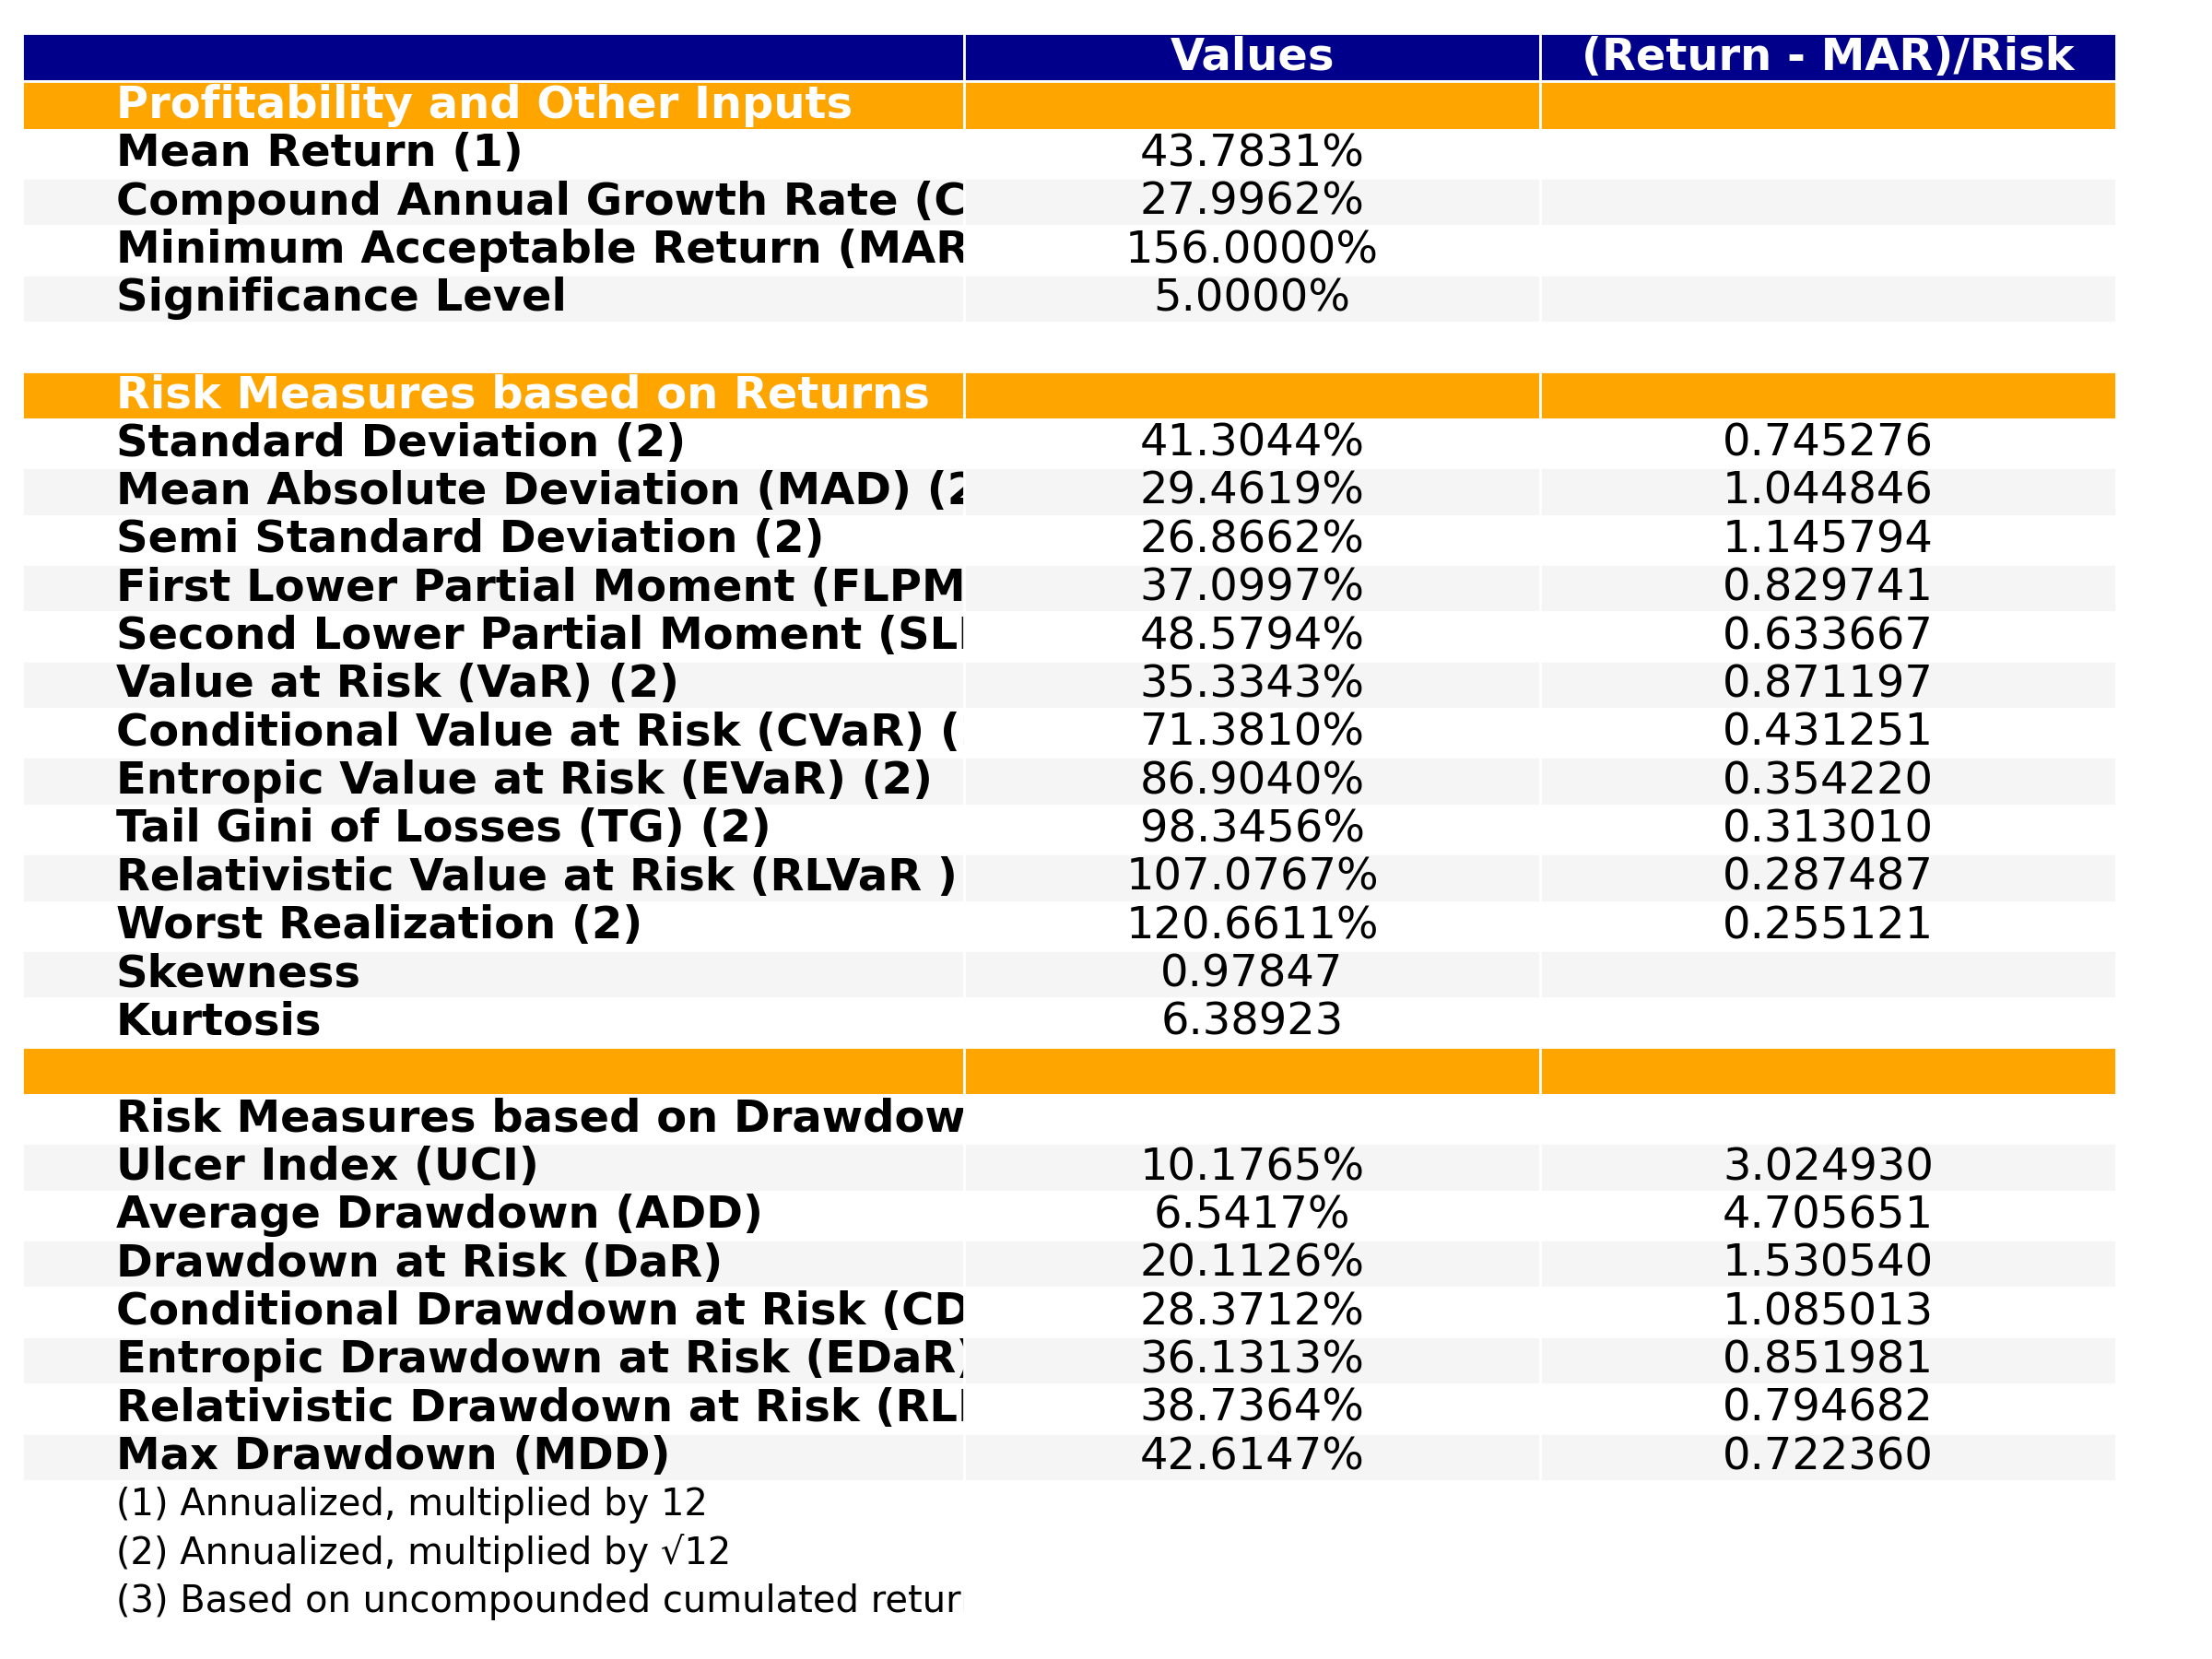

In [ ]:
table = rp.plot_table(returns=Y,
                      w = w,
                      MAR = 13/100,
                      alpha = 0.05,
                      ax = None,
                      t_factor = 12)